In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import csv
import pandas as pd
import matplotlib
import matplotlib.gridspec as gridspec
matplotlib.rc('xtick', labelsize=23) 
matplotlib.rc('ytick', labelsize=23) 

# RV fitting

## Read in RV data

The offsets to get from the relative RVs I provided to an absolute scale are as follows:

K03835482: -64.075 +/- 0.104 km/s

K06233093: -55.631 +/- 0.054 km/s

K12254688: 19.832 +/- 0.053 km/s

K08145411: -27.585 +/- 0.069 km/s


You need to add these values to the derived center of mass velocities to get absolute center of mass velocities. This won't affect your fitting, of course -- just use the RVs provided. If you write this up, though, you'll want to report the actual RV of each system, and not just the relative RVs.

In [2]:
# input the folder name
RVfolder = 'RVdata/'  

# input the file names
RVfiles = ['K03835482.vzero.txt', 'K06233093.vzero.txt', 'K08145411.vzero.txt', 'K12254688.vzero.txt'] 

# make a list of the RV offset to the absolute center of mass velocities
RVoffset = np.array([-64.075, -55.631, 19.832, -27.585])

# make an empty list called data_all where we will save the data...
data_all = []

# start a for loop, looping through our 4 data files
for file in RVfiles:
    
    # pulls in RV file, set it equal to variable called "data" 
    data = pd.read_csv(RVfolder+file, header=None, delim_whitespace=True)

    # add header to each column with information on the data in that column
    data.columns = ('time [days]', 'radial velocities [m/s]', 'radial velocity errors [m/s]')
    
    # convert RVs and RV errors from m/s to km/s
    data['radial velocities [m/s]'] = data['radial velocities [m/s]']/1000.
    data['radial velocity errors [m/s]'] = data['radial velocity errors [m/s]']/1000.
    
    # change RV and RV errors header to list units in km/s
    data.rename(columns={'radial velocities [m/s]': 'radial velocities [km/s]'}, inplace=True)
    data.rename(columns={'radial velocity errors [m/s]': 'radial velocity errors [km/s]'}, inplace=True)
    
    # convert times to BJD - 2,454,833 BJD and change units in header
    data['time [days]'] = data['time [days]'] - 2454833
    data.rename(columns={'time [days]': 'time [BJD - 2454833]'}, inplace=True)
    
    # append data for one star onto data_all
    data_all.append(data)

    

# Now let's plot up the data:

In [3]:
colors = ["#7066bc", "#90a240", "#b34f93", "#50b47b"]

In [4]:
for data in data_all:
    print(data)


    time [BJD - 2454833]  radial velocities [km/s]  \
0            2840.681063                   -1.0356   
1            3004.003694                    7.4963   
2            3019.955196                    8.8375   
3            3054.910814                   11.7285   
4            3067.950751                   12.6989   
5            3100.852629                   15.0426   
6            3160.757563                   16.9943   
7            3170.685366                   16.9936   
8            3186.721619                   16.8829   
9            3208.635833                   16.2637   
10           3220.657206                   15.8010   
11           3236.605155                   14.8548   
12           3250.611822                   13.9682   
13           3343.024148                    6.5759   
14           3380.987350                    3.5873   
15           3393.954024                    2.7280   
16           3427.922768                    0.8324   
17           3447.758173    

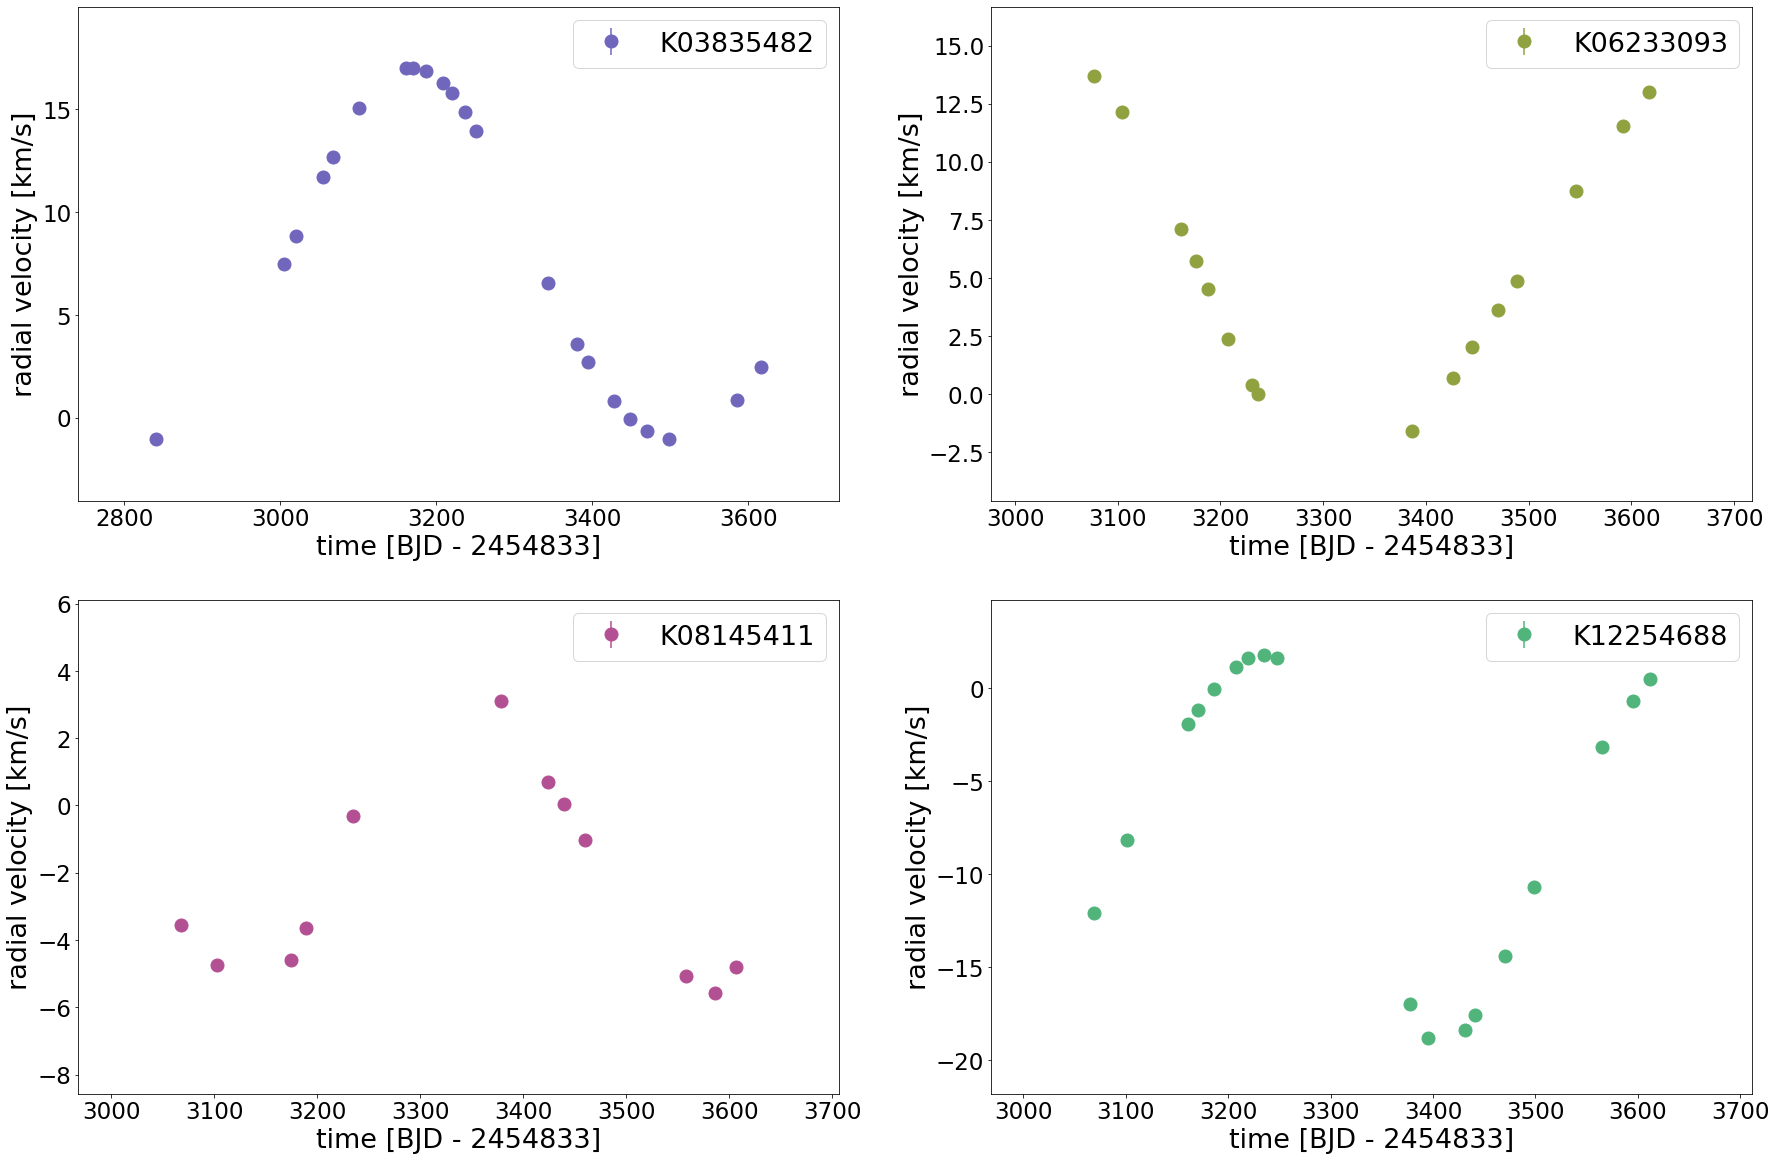

In [5]:
fig, ax = plt.subplots(2,2, figsize = [30,20])
index = 0
columns = [0,0,1,1]
rows = [0,1,0,1]
for data in data_all:
    time, rv, rv_err = data['time [BJD - 2454833]'], data['radial velocities [km/s]'], data['radial velocity errors [km/s]']
    ii = columns[index]
    jj = rows[index]
    ax[ii][jj].errorbar(time, rv, yerr = rv_err, marker = 'o', linestyle = '', label = RVfiles[index][:-10], color = colors[index], markersize = 13)
    ax[ii][jj].set_xlabel('time [BJD - 2454833]', fontsize = 27)
    ax[ii][jj].set_ylabel('radial velocity [km/s]', fontsize = 27)
    
    ax[ii][jj].set_xlim([np.min(time)-100, np.max(time)+100])
    ax[ii][jj].set_ylim([np.min(rv)-3, np.max(rv)+3])
    ax[ii][jj].legend(fontsize = 27)

    index += 1

## RV results from Masuda et al. 2019 IAU Symposium: https://arxiv.org/pdf/2001.04448.pdf

RV params = period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma, jitter

KIC params = period, ttran (BJD=2454833), e, omega (deg), K (km/s), gamma (km/s), jitter (m/s)

-------------

KIC3835482   =  683.266,

KIC6233093   = 

KIC12254688  =  

KIC8145411   =  



In [6]:
from funcsRV import *

In [7]:
#pull in original parameters from Masuda IAU values
#pmod = period, ttran (BJD=2454833), e, omega (deg), K (km/s), gamma (km/s), jitter (m/s)
pmod_03835482 = ['K03835482', 683.266, 591.628, 0.062, 4, 9.07, 7.45, 13]
pmod_06233093 = ['K06233093', 727.979, 260.678, 0.123, 112, 9.5, 6.61, 17]
pmod_08145411 = ['K08145411', 455.83, 267.97, 0.13, -93, 4.59, -0.78, 150]
pmod_12254688 = ['K12254688', 418.718, 404.583, 0.180, 128, 10.44, -7.49, 17]

#turn e and omega into sqrte*cos(omega) and sqrte*sin(omega)
#turn jitter into km/s
p_03835482 = pmod_03835482[0:3]+ [np.sqrt(pmod_03835482[3])*np.cos(np.radians(pmod_03835482[4]))] + [np.sqrt(pmod_03835482[3])*np.sin(np.radians(pmod_03835482[4]))] + pmod_03835482[5:7] + [pmod_03835482[7]/1000.]
p_06233093 = pmod_06233093[0:3]+ [np.sqrt(pmod_06233093[3])*np.cos(np.radians(pmod_06233093[4]))] + [np.sqrt(pmod_06233093[3])*np.sin(np.radians(pmod_06233093[4]))] + pmod_06233093[5:7] + [pmod_06233093[7]/1000.]
p_08145411 = pmod_08145411[0:3]+ [np.sqrt(pmod_08145411[3])*np.cos(np.radians(pmod_08145411[4]))] + [np.sqrt(pmod_08145411[3])*np.sin(np.radians(pmod_08145411[4]))] + pmod_08145411[5:7] + [pmod_08145411[7]/1000.]
p_12254688 = pmod_12254688[0:3]+ [np.sqrt(pmod_12254688[3])*np.cos(np.radians(pmod_12254688[4]))] + [np.sqrt(pmod_12254688[3])*np.sin(np.radians(pmod_12254688[4]))] + pmod_12254688[5:7] + [pmod_12254688[7]/1000.]

p_all = [p_03835482, p_06233093, p_08145411, p_12254688]
for p in p_all: print(p)

['K03835482', 683.266, 591.628, 0.24839144536595595, 0.017369221888481945, 9.07, 7.45, 0.013]
['K06233093', 727.979, 260.678, -0.13137961135264847, 0.3251759488658825, 9.5, 6.61, 0.017]
['K08145411', 455.83, 267.97, -0.01886999737843737, -0.36006099927503643, 4.59, -0.78, 0.15]
['K12254688', 418.718, 404.583, -0.2612030424708523, 0.3343246485139409, 10.44, -7.49, 0.017]


In [8]:
#change t_tran to be in the middle of the RV observations 
for ii in range(0, len(p_all)):
    data = data_all[ii]
    time = data['time [BJD - 2454833]']
    min_time = np.min(time)
    t_tran = p_all[ii][2]
    period = p_all[ii][1]
    while t_tran < min_time:
        t_tran += period
    
    p_all[ii][2] = t_tran
    print(p_all[ii])

['K03835482', 683.266, 3324.692, 0.24839144536595595, 0.017369221888481945, 9.07, 7.45, 0.013]
['K06233093', 727.979, 3172.594, -0.13137961135264847, 0.3251759488658825, 9.5, 6.61, 0.017]
['K08145411', 455.83, 3458.7799999999997, -0.01886999737843737, -0.36006099927503643, 4.59, -0.78, 0.15]
['K12254688', 418.718, 3335.6089999999995, -0.2612030424708523, 0.3343246485139409, 10.44, -7.49, 0.017]


In [9]:
RVmodels = []
for p in p_all:
    period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma = p[1:-1]
    RVmodels.append(RV_model(time, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma))

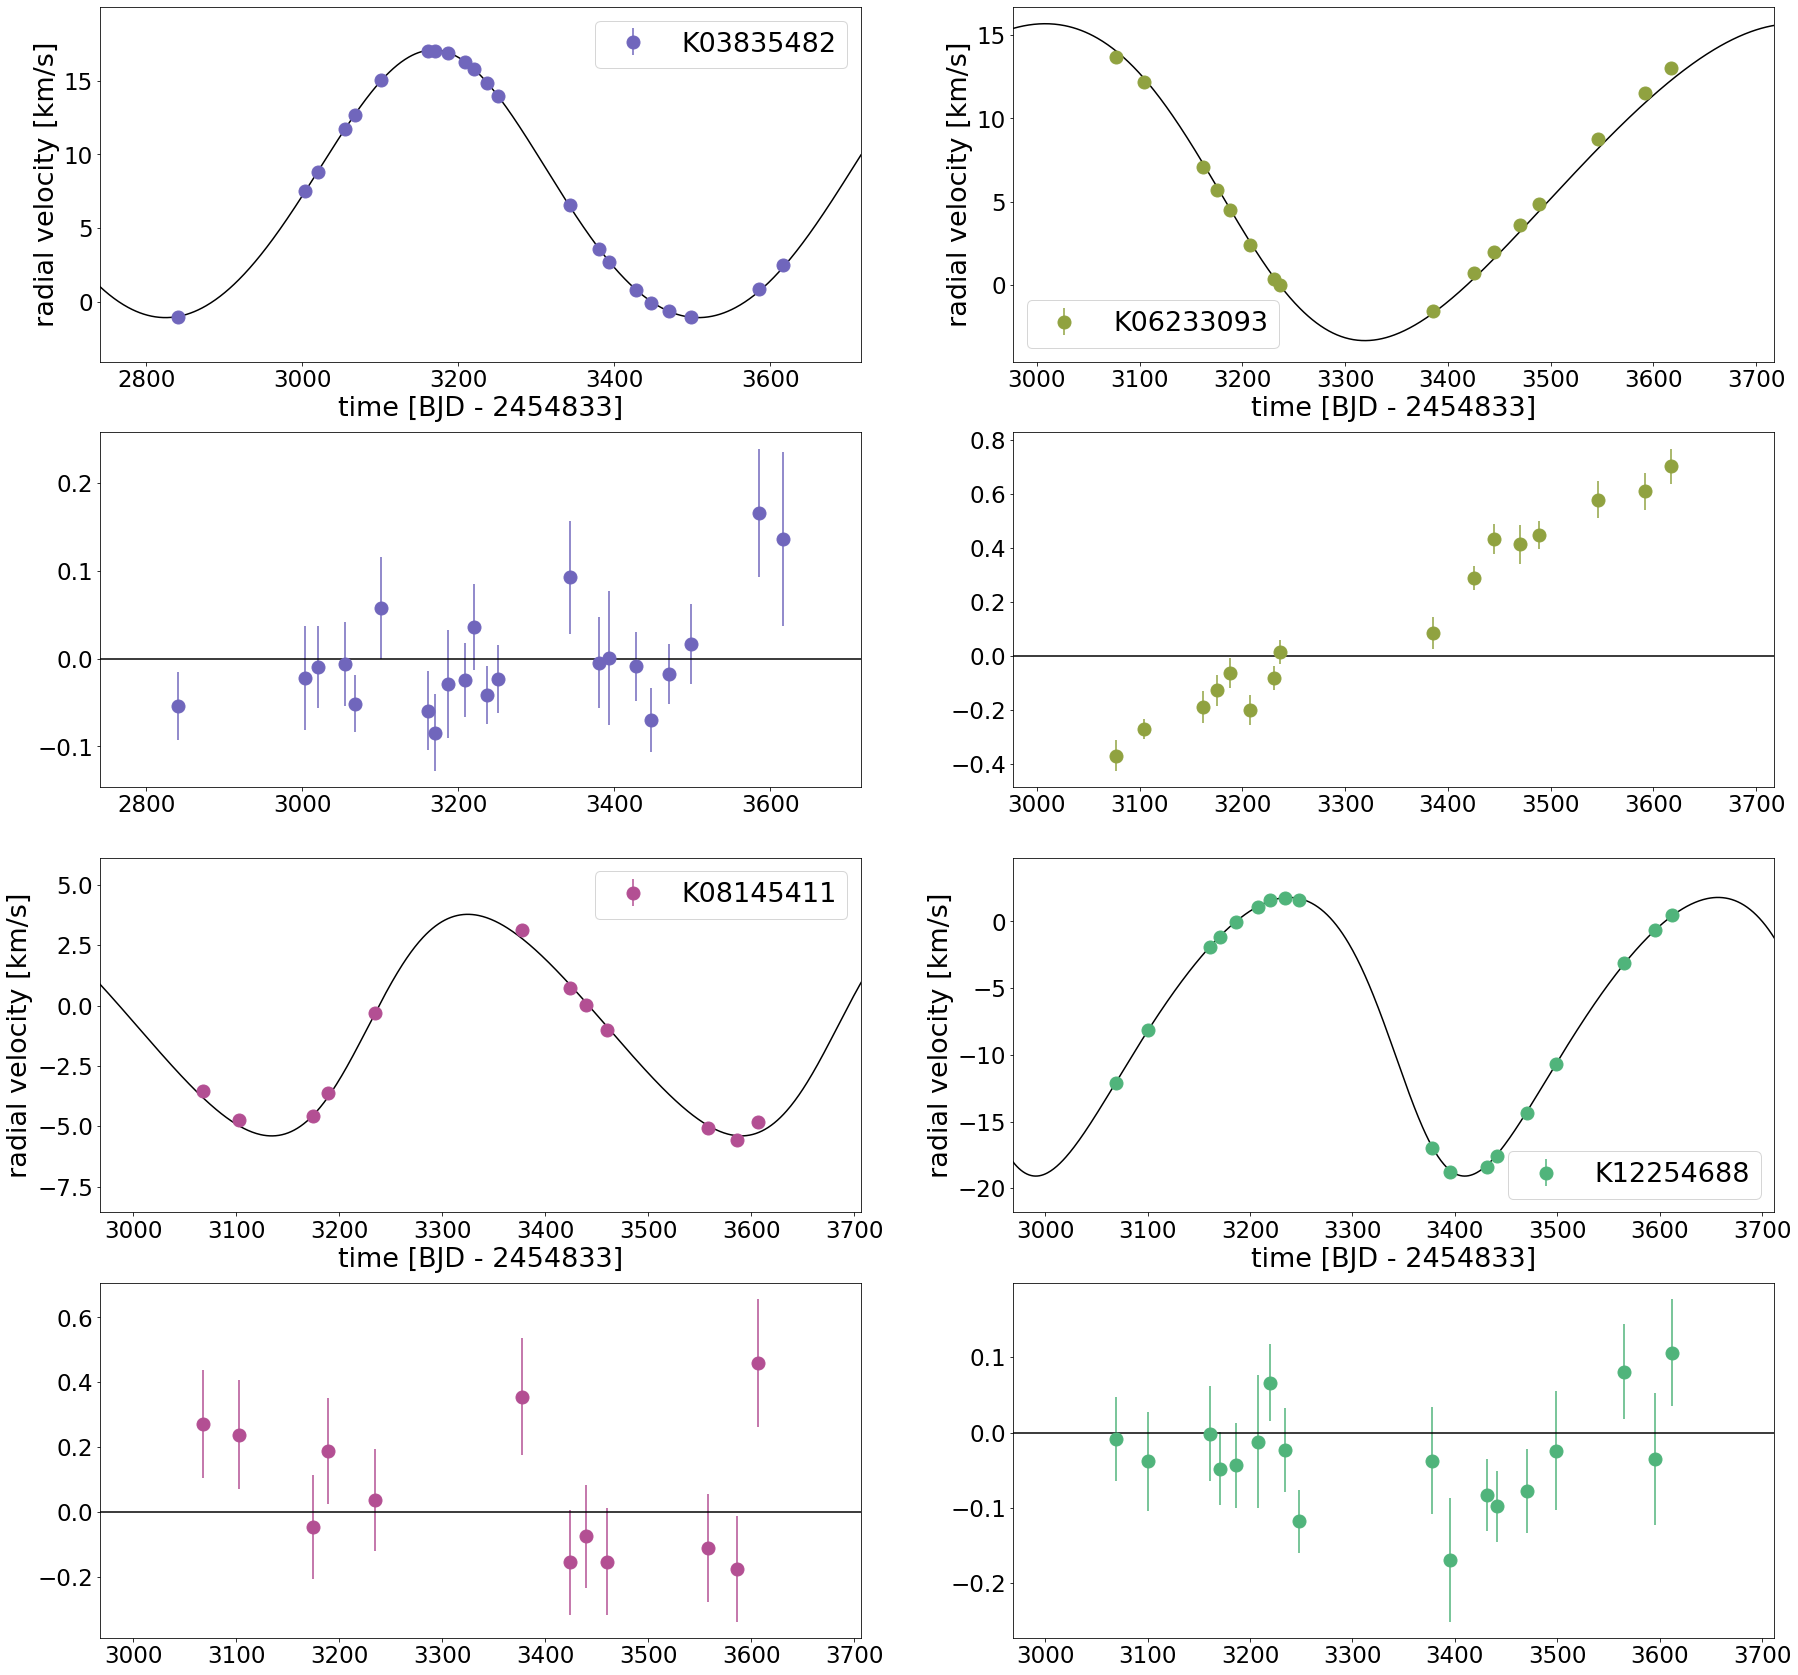

In [10]:
fig, ax = plt.subplots(4,2, figsize = [30,30])
index = 0
columns = [0,0,2,2]
resid_columns = [1,1,3,3]
rows = [0,1,0,1]
for index in range(0, len(data_all)):
    ii = columns[index]
    jj = rows[index]
    kk = resid_columns[index]
    
    params = p_all[index]
    data = data_all[index]
    
    kic = params[0]    
    period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma = params[1:-1]
    jitter = params[-1]
    
    time, rv, rv_err = data['time [BJD - 2454833]'], data['radial velocities [km/s]'], data['radial velocity errors [km/s]']
    
    time_model = np.arange(np.min(time)*0.95, np.max(time)*1.05)
    RVmodel = RV_model(time_model, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
    
    ax[ii][jj].plot(time_model, RVmodel, color = 'k')    
    
    ax[ii][jj].errorbar(time, rv, yerr = np.sqrt(rv_err**2. + jitter**2.), marker = 'o', linestyle = '', label = kic, color = colors[index], markersize = 13)
    ax[ii][jj].set_xlabel('time [BJD - 2454833]', fontsize = 27)
    ax[ii][jj].set_ylabel('radial velocity [km/s]', fontsize = 27)
    
    RVresids = RV_model(time, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
    ax[kk][jj].plot([np.min(time)*0.95, np.max(time)*1.05], [0., 0.], color = 'k')
    ax[kk][jj].errorbar(time, rv - RVresids, yerr = np.sqrt(rv_err**2. + jitter**2.), fmt = 'o', markersize = 13,  color = colors[index])
    ax[kk][jj].get_shared_x_axes().join(ax[kk][jj], ax[ii][jj])
    
    ax[ii][jj].set_xlim([np.min(time)-100, np.max(time)+100])
    ax[ii][jj].set_ylim([np.min(rv)-3, np.max(rv)+3])
    ax[ii][jj].legend(fontsize = 27)

    index += 1

In [11]:
def runMCMC(p, t, rv, rvErr, outfile, niter=10000, nwalkers=50):

    """
    Run the MCMC Orbital fit to Spectroscopic RV Observations

    Input
    -----
    p : ndarray
        Orbital parameters. See RV model in funcs.py for order
    t, rv, rvErr : Ndarray
        times, RV, and RV errors of the data.
    outfile : string
        name of output file where MCMC chain is stored
    niter : int, optional
            number of MCMC iterations to run. Default = 10,000
    nwalkers : int, optional
        number of MCMC walkers in modeling. Default = 50

    Returns
    ------
    String stating "MCMC complete"

    (Outputs MCMC chain into file labeled whatever input into variable: outfile)


    """

    ndim = len(p)



    #start walkers in a ball near the optimal solution
    startlocs = [p + initrange(p) * np.random.randn(ndim) for i in np.arange(nwalkers)]

    #run emcee MCMC code
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args = [t, rv, rvErr])

    #clear output file
    ofile = open(outfile, 'w')
    ofile.close()

    iternum = 1
    #run the MCMC...record parameters for every walker at every step
    for result in sampler.sample(startlocs, iterations = niter, store = False):
        pos = result.coords
        ofile = open(outfile, 'a')

        #write iteration number, walker number, and log likelihood
        #and value of parameters for the step
        for walker in np.arange(pos.shape[0]):
            ofile.write('{0} {1} {2} {3}\n'.format(iternum, walker, str(result.log_prob[walker]), " ".join([str(x) for x in pos[walker]])))
        
        ofile.close()


        #keep track of step number
        mod = iternum % 100
        if mod == 0:
            print(iternum)
            print(pos[0])

        iternum += 1
    return "MCMC complete"

In [15]:

for ii in range(0, len(p_all)):
    data = data_all[ii]
    time, rv, rv_err = data['time [BJD - 2454833]'], data['radial velocities [km/s]'], data['radial velocity errors [km/s]']
    params = p_all[ii][1:]
    kic = p_all[ii][0]
    filename = 'chain_test_' + kic + '_new.csv'
    
    runMCMC(params, time, rv, rv_err, filename, niter=1000, nwalkers=50)

 

10000
[6.76574494e+02 3.32527354e+03 2.31485335e-01 3.35903664e-03
 9.05224911e+00 7.49606751e+00 3.97972335e-03]
20000
[6.81516417e+02 3.32515820e+03 2.42297703e-01 5.08113491e-03
 9.06783994e+00 7.45082027e+00 4.04567966e-03]
30000
[6.77510419e+02 3.32503330e+03 2.36529176e-01 7.82266249e-03
 9.04678989e+00 7.49633760e+00 8.05278215e-03]
40000
[ 6.76558505e+02  3.32551699e+03  2.33601134e-01 -3.50525588e-03
  9.06492020e+00  7.50121850e+00  9.82642959e-03]
50000
[6.77410626e+02 3.32581846e+03 2.30620538e-01 8.06825632e-03
 9.04168316e+00 7.48567424e+00 2.85010612e-02]
60000
[6.79421045e+02 3.32561984e+03 2.36241363e-01 5.35213170e-03
 9.03890716e+00 7.47474786e+00 1.86249926e-04]
70000
[6.78053518e+02 3.32605732e+03 2.30823075e-01 4.09019507e-04
 9.06428997e+00 7.49431386e+00 1.17341247e-02]
80000
[6.79300285e+02 3.32595915e+03 2.29701761e-01 1.30162719e-02
 9.06218137e+00 7.48721947e+00 2.04172615e-02]
90000
[6.80179468e+02 3.32487958e+03 2.38526159e-01 2.82967472e-02
 9.06926218e+0

/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:99: RuntimeWarning: invalid value encountered in sqrt
  tau = (ttran + np.sqrt(edif) * period / (2 * np.pi) *
/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:100: RuntimeWarning: invalid value encountered in sqrt
  (e * np.sin(fcen) / (1. + e * np.cos(fcen)) - 2. / np.sqrt(edif) *
/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:101: RuntimeWarning: invalid value encountered in sqrt
  np.arctan(np.sqrt(edif) * np.tan(fcen / 2.) / (1. + e))))
/Users/Danielyahalomi/Documents/SRMP/Self-Lensing/RV/funcsRV.py:113: RuntimeWarning: invalid value encountered in sqrt
  tanf2 = np.sqrt((1. + e) / (1. - e)) * np.tan(E / 2.)


10000
[ 4.39209963e+02  3.45647411e+03 -8.50461487e-02 -3.19244004e-01
  4.60252167e+00 -6.87652196e-01  1.46150421e-01]
20000
[ 4.46718305e+02  3.44331221e+03  1.61531513e-01 -3.21063427e-01
  4.91951847e+00 -5.73383276e-01  1.67399465e-01]
30000
[ 4.46354444e+02  3.44824060e+03  7.15634164e-02 -3.84734391e-01
  4.77150619e+00 -5.87718097e-01  1.10096985e-01]
40000
[ 4.39593380e+02  3.44886101e+03  5.06576465e-03 -3.88515965e-01
  4.87127962e+00 -4.50416398e-01  2.06040259e-01]
50000
[ 4.47389238e+02  3.45203219e+03  2.46682749e-02 -3.70943033e-01
  4.65265389e+00 -6.03420791e-01  1.61357008e-01]
60000
[ 4.33299422e+02  3.46070497e+03 -2.15709851e-01 -2.39867207e-01
  4.48822754e+00 -7.48477562e-01  2.25878736e-01]
70000
[ 4.49247979e+02  3.46063458e+03 -9.82311446e-02 -3.42919883e-01
  4.61716564e+00 -7.70735600e-01  1.42859101e-01]
80000
[ 4.42438870e+02  3.45364652e+03 -6.13510664e-02 -3.24555227e-01
  4.75802244e+00 -6.53257491e-01  1.37299900e-01]
90000
[ 4.39745703e+02  3.444510

In [12]:
from analyzeRV import *

K03835482
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


$P$ [days]
max = 678.9596647961264
median = 678.6910689299261
- sigma = -1.601801456276121
+ sigma = 1.6725785434839509

$t_{tran}$ [BJD - 2454833]
max = 3325.242579205692
median = 3325.4630662476457
- sigma = -0.5149145735090315
+ sigma = 0.4745174020572449

$\sqrt{e} cos\omega$
max = 0.23560097334922242
median = 0.23447536145301412
- sigma = -0.004998029511230462
+ sigma = 0.00471768403429651

$\sqrt{e} sin\omega$
max = 0.014965511975068745
median = 0.011289122645239074
- sigma = -0.010513013764084351
+ sigma = 0.010477214000575519

$K$ [km/s]
max = 9.044637410760204
median = 9.049392845534065
- sigma = -0.01536152583291539
+ sigma = 0.014607383046030264

$\gamma [km/s]$
max = 7.478449872670247
median = 7.480203340598162
- sigma = -0.0174847435383505
+ sigma = 0.018110187434582592

$\sigma_{j} [km/s]$
max = 0.0007329879007412984
median = 0.013959820324870543
- sigma = -0.009492312826760716
+ sigma = 0.014136064524698911



K06233093
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


$P$ [days]
max = 692.1823907678327
median = 692.4523017793508
- sigma = -21.791019396357115
+ sigma = 28.33813219248077

$t_{tran}$ [BJD - 2454833]
max = 3173.340688065
median = 3173.3103641627586
- sigma = -2.273442268216968
+ sigma = 1.8195109302910168

$\sqrt{e} cos\omega$
max = -0.1125745764033052
median = -0.11539542099995775
- sigma = -0.05495913683774292
+ sigma = 0.05146101788057017

$\sqrt{e} sin\omega$
max = 0.30127869019346215
median = 0.2994903084358704
- sigma = -0.014594542736607874
+ sigma = 0.009738790827368171

$K$ [km/s]
max = 9.202924623853555
median = 9.224119179656526
- sigma = -0.21094101403730825
+ sigma = 0.26666502039514484

$\gamma [km/s]$
max = 6.270830410942912
median = 6.272355366007777
- sigma = -0.3051746858569553
+ sigma = 0.39002958809382093

$\sigma_{j} [km/s]$
max = 0.024713918012954243
median = 0.054829950936378144
- sigma = -0.02505462271389468
+ sigma = 0.030905228828030443



K08145411
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


$P$ [days]
max = 442.1941820151671
median = 442.47897873798934
- sigma = -4.756061364638526
+ sigma = 5.546972829799074

$t_{tran}$ [BJD - 2454833]
max = 3452.8181902959327
median = 3451.1405879014133
- sigma = -5.457300684369329
+ sigma = 5.277795868078101

$\sqrt{e} cos\omega$
max = -0.022773664880382287
median = 0.010738085746951058
- sigma = -0.08776815726355308
+ sigma = 0.08486602519396416

$\sqrt{e} sin\omega$
max = -0.3378788574792725
median = -0.33361835858303474
- sigma = -0.03400006253624355
+ sigma = 0.04427262961747336

$K$ [km/s]
max = 4.721332861932564
median = 4.74852942548848
- sigma = -0.1769096644904984
+ sigma = 0.19909645331525105

$\gamma [km/s]$
max = -0.623170103311017
median = -0.5999543962512973
- sigma = -0.11665033274000114
+ sigma = 0.10934617753784437

$\sigma_{j} [km/s]$
max = 0.09421478039171065
median = 0.18539904538096943
- sigma = -0.05762298817138897
+ sigma = 0.09476125697404733



K12254688
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


$P$ [days]
max = 418.30849655301176
median = 418.42096352936437
- sigma = -0.4769768222649873
+ sigma = 0.4734501772110207

$t_{tran}$ [BJD - 2454833]
max = 3335.6775068925976
median = 3335.4830632244266
- sigma = -0.7617038542798582
+ sigma = 0.7727151817171034

$\sqrt{e} cos\omega$
max = -0.26923406048661924
median = -0.26661089337998245
- sigma = -0.00711463714068461
+ sigma = 0.0072050620184840874

$\sqrt{e} sin\omega$
max = 0.3255100305470028
median = 0.3270975246005382
- sigma = -0.00460022844317276
+ sigma = 0.004843330459375628

$K$ [km/s]
max = 10.464506429508031
median = 10.465366018892425
- sigma = -0.02949065023141806
+ sigma = 0.03160512026202156

$\gamma [km/s]$
max = -7.541845160346047
median = -7.5451077203914405
- sigma = -0.03537070478603166
+ sigma = 0.03797601353517166

$\sigma_{j} [km/s]$
max = 0.006604699994746868
median = 0.03328857866136614
- sigma = -0.02126882702070957
+ sigma = 0.025920105354790834





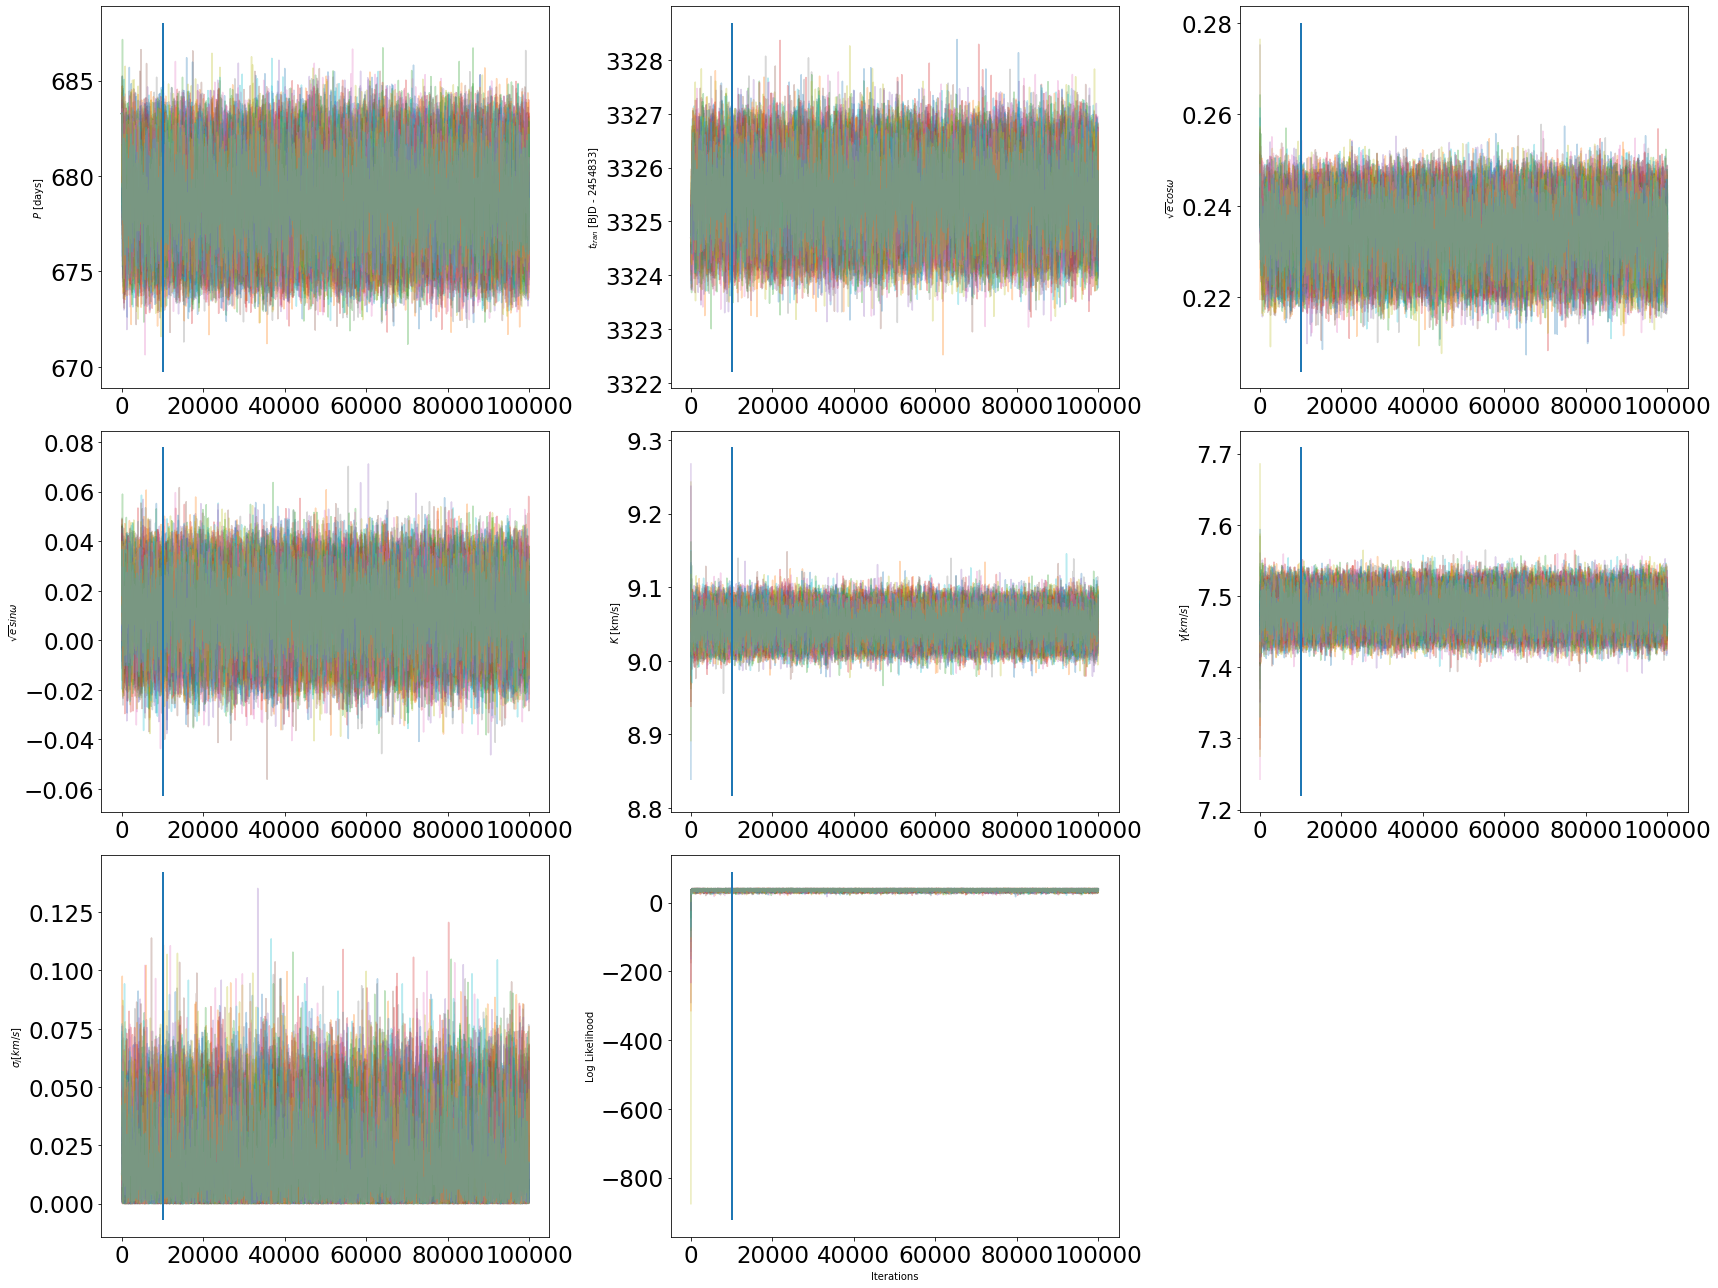

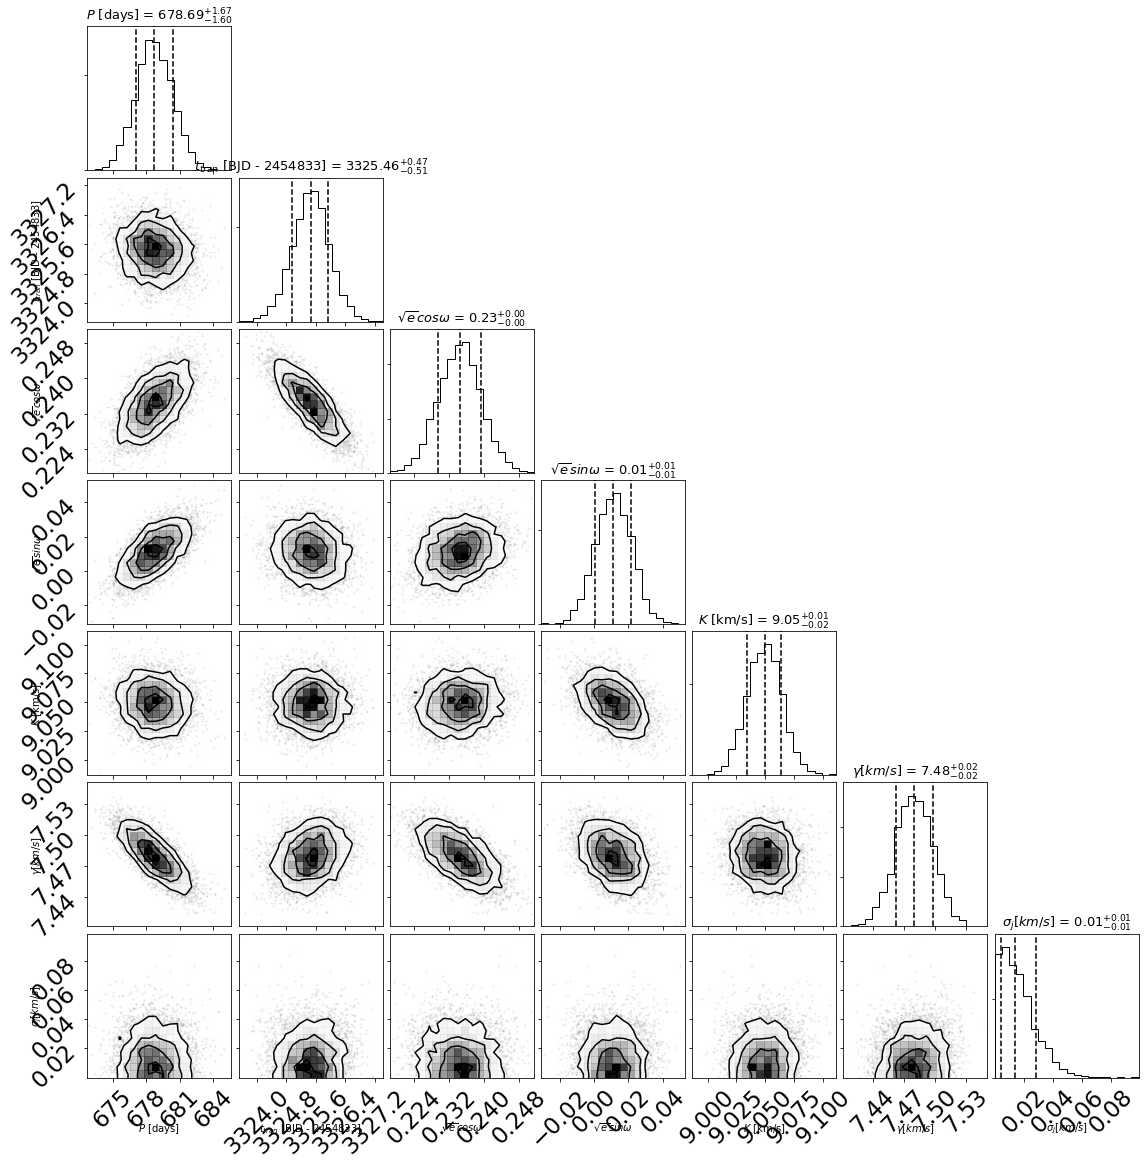

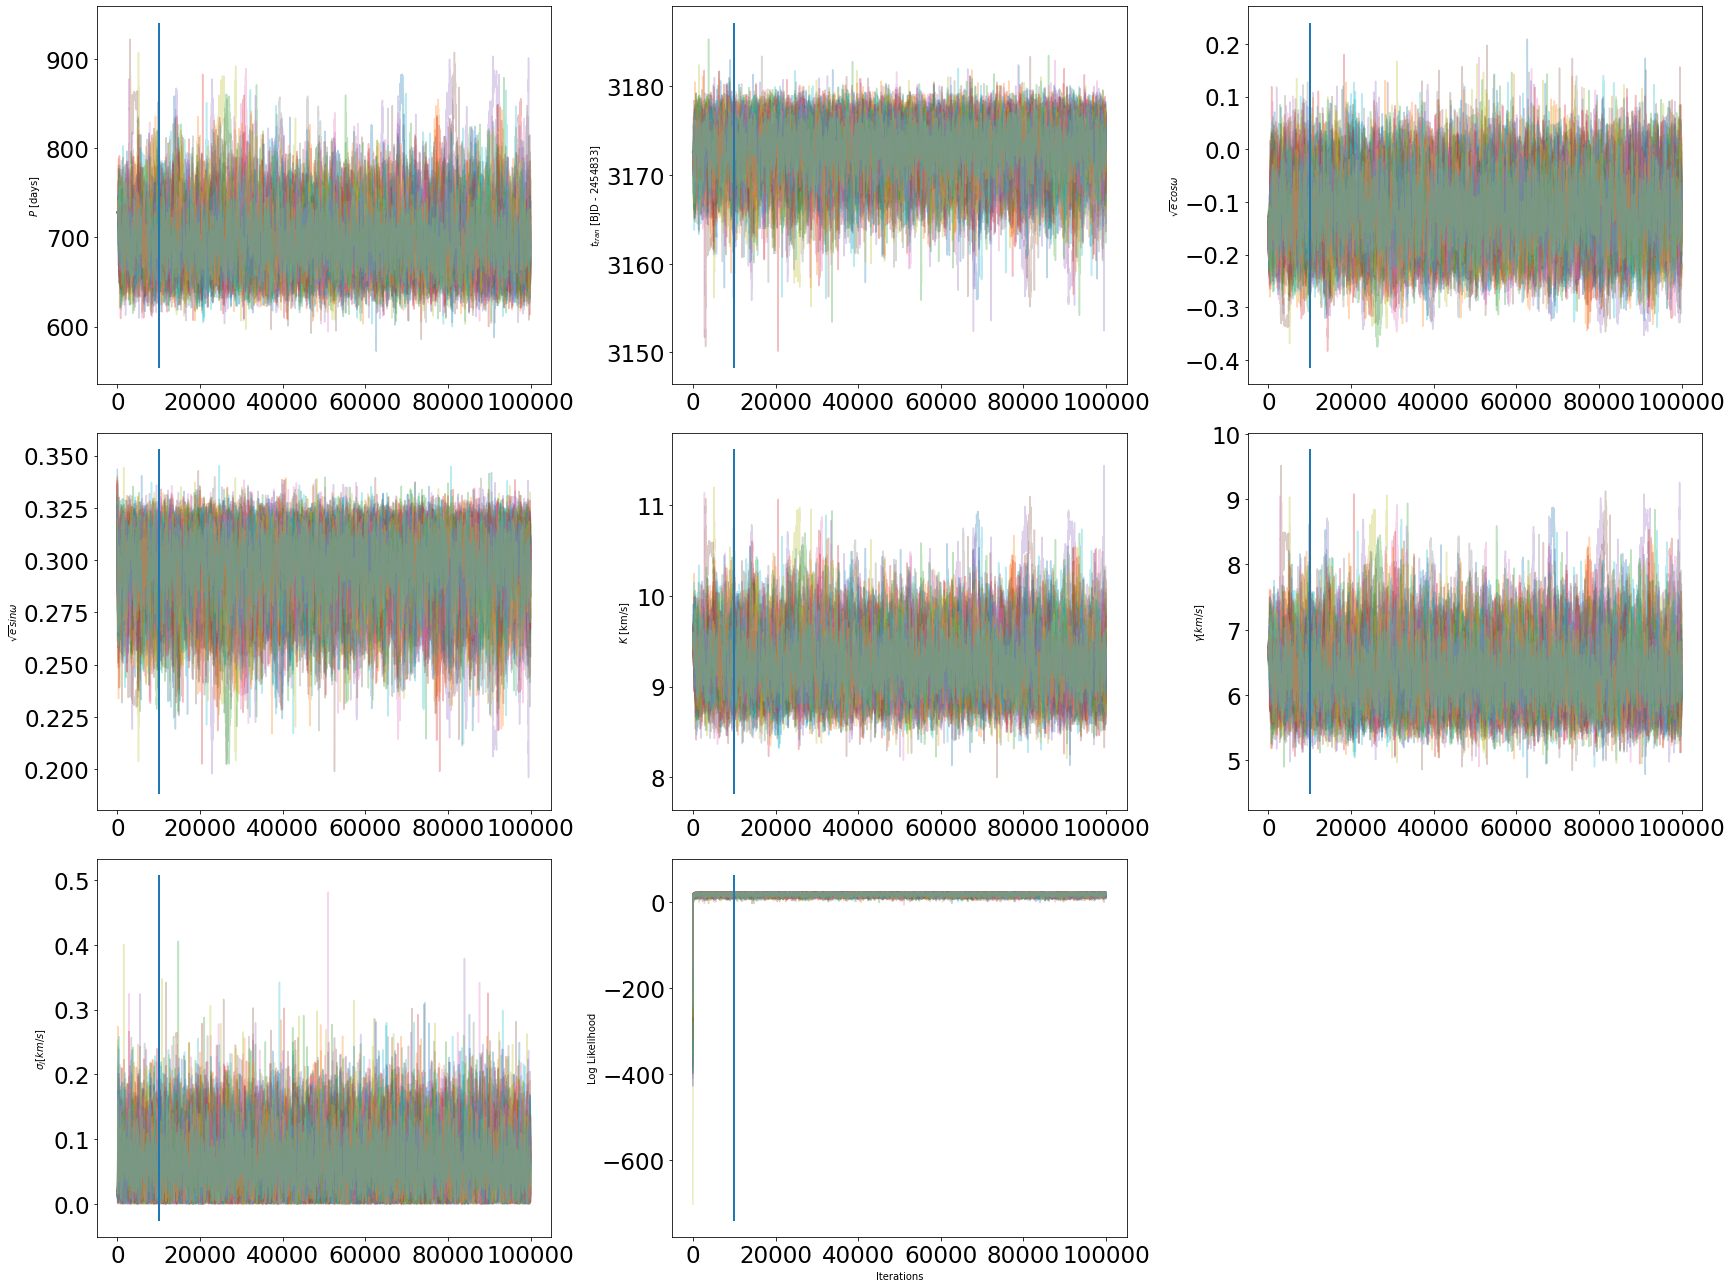

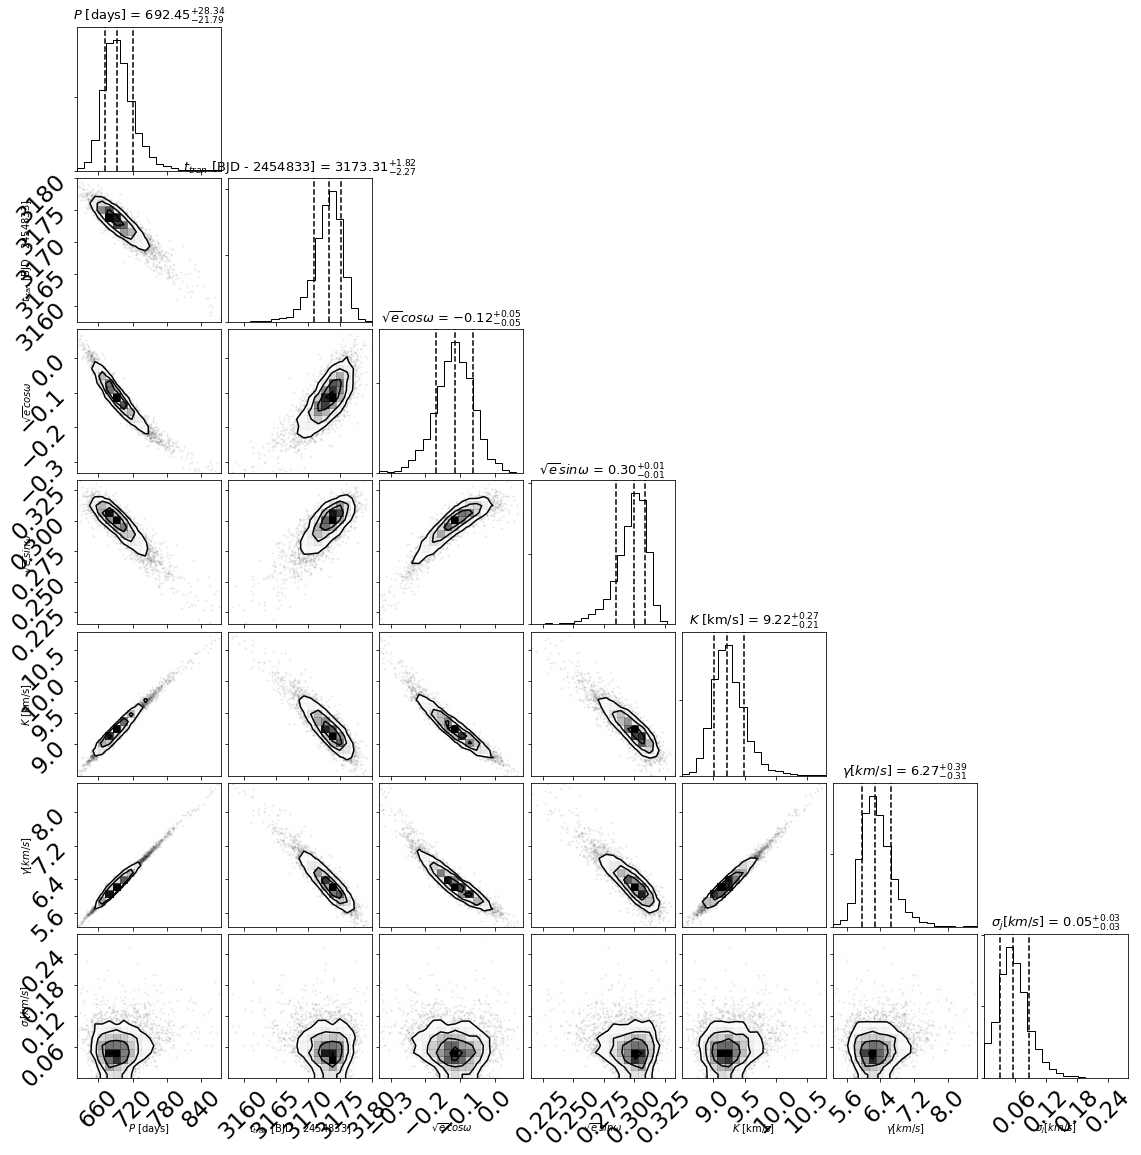

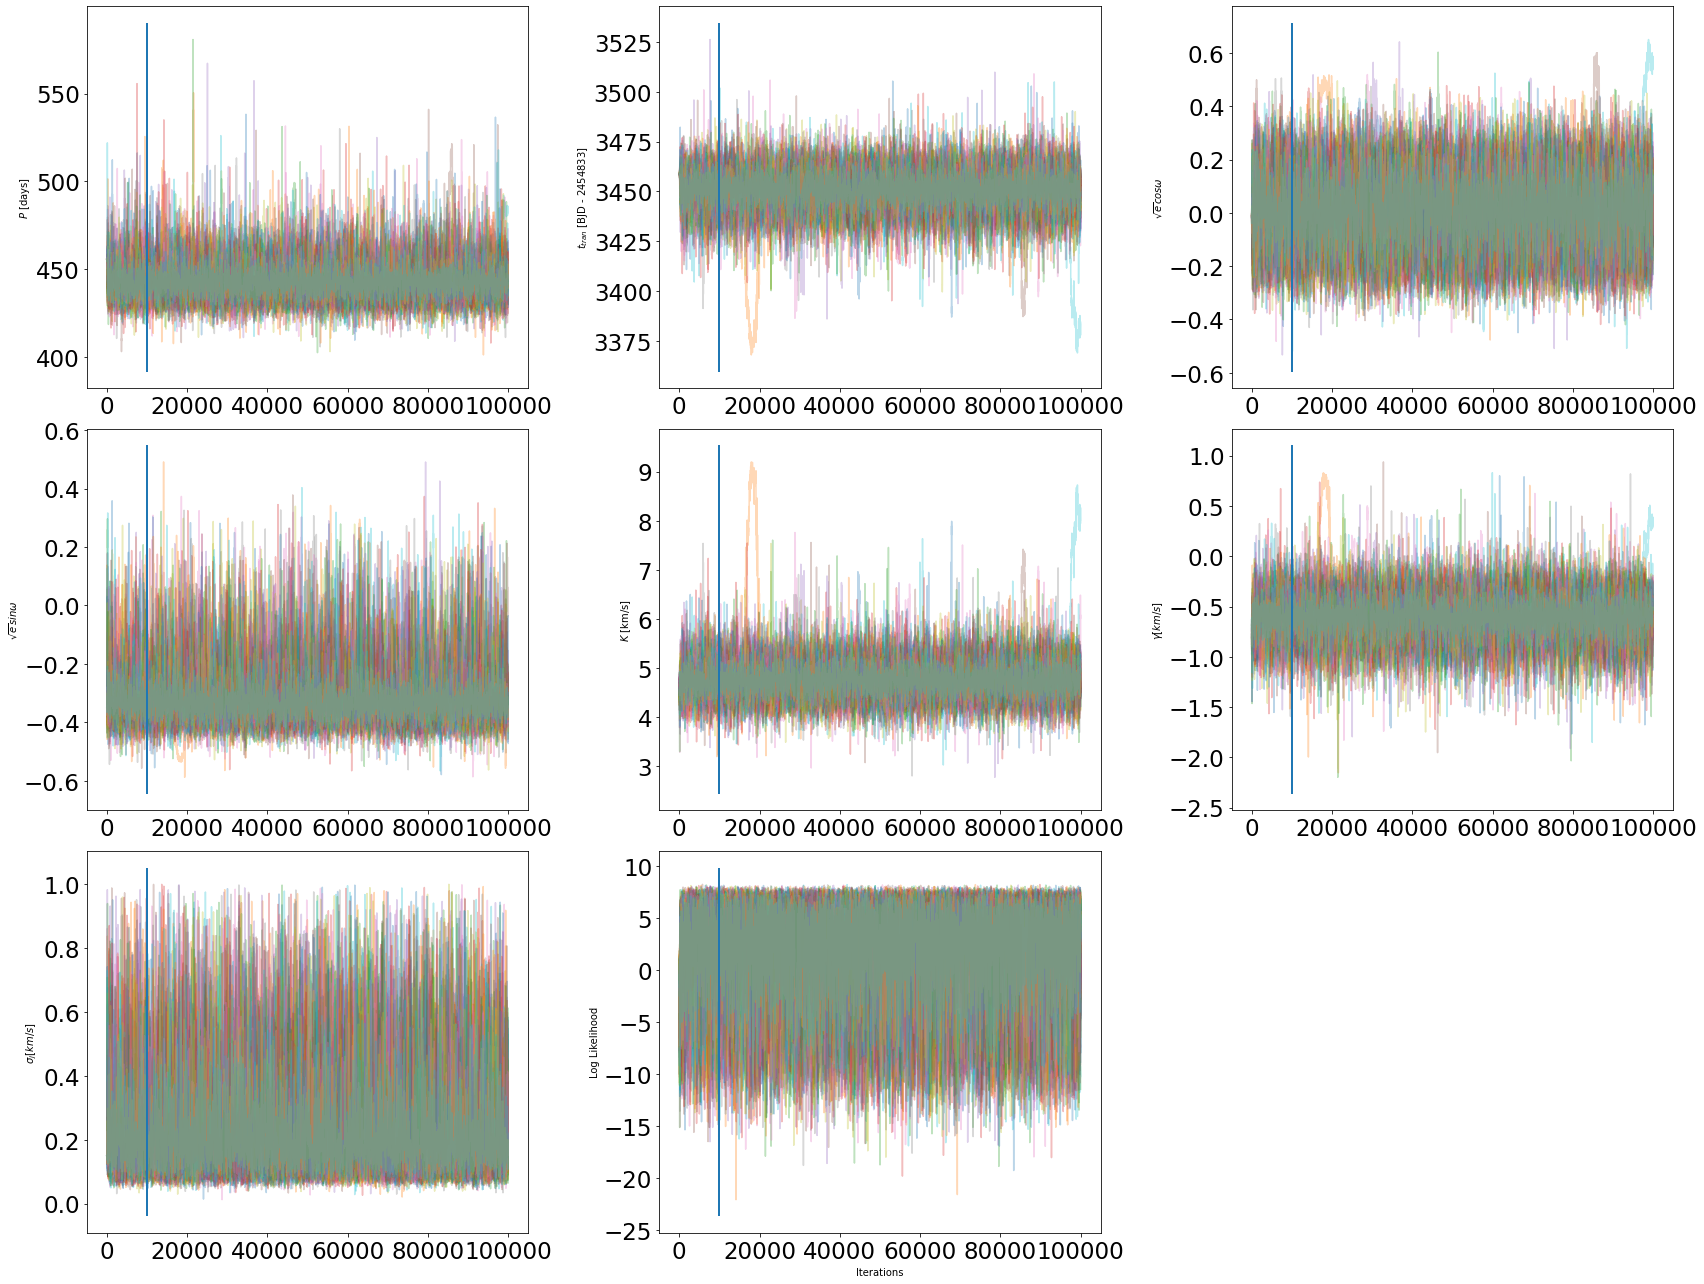

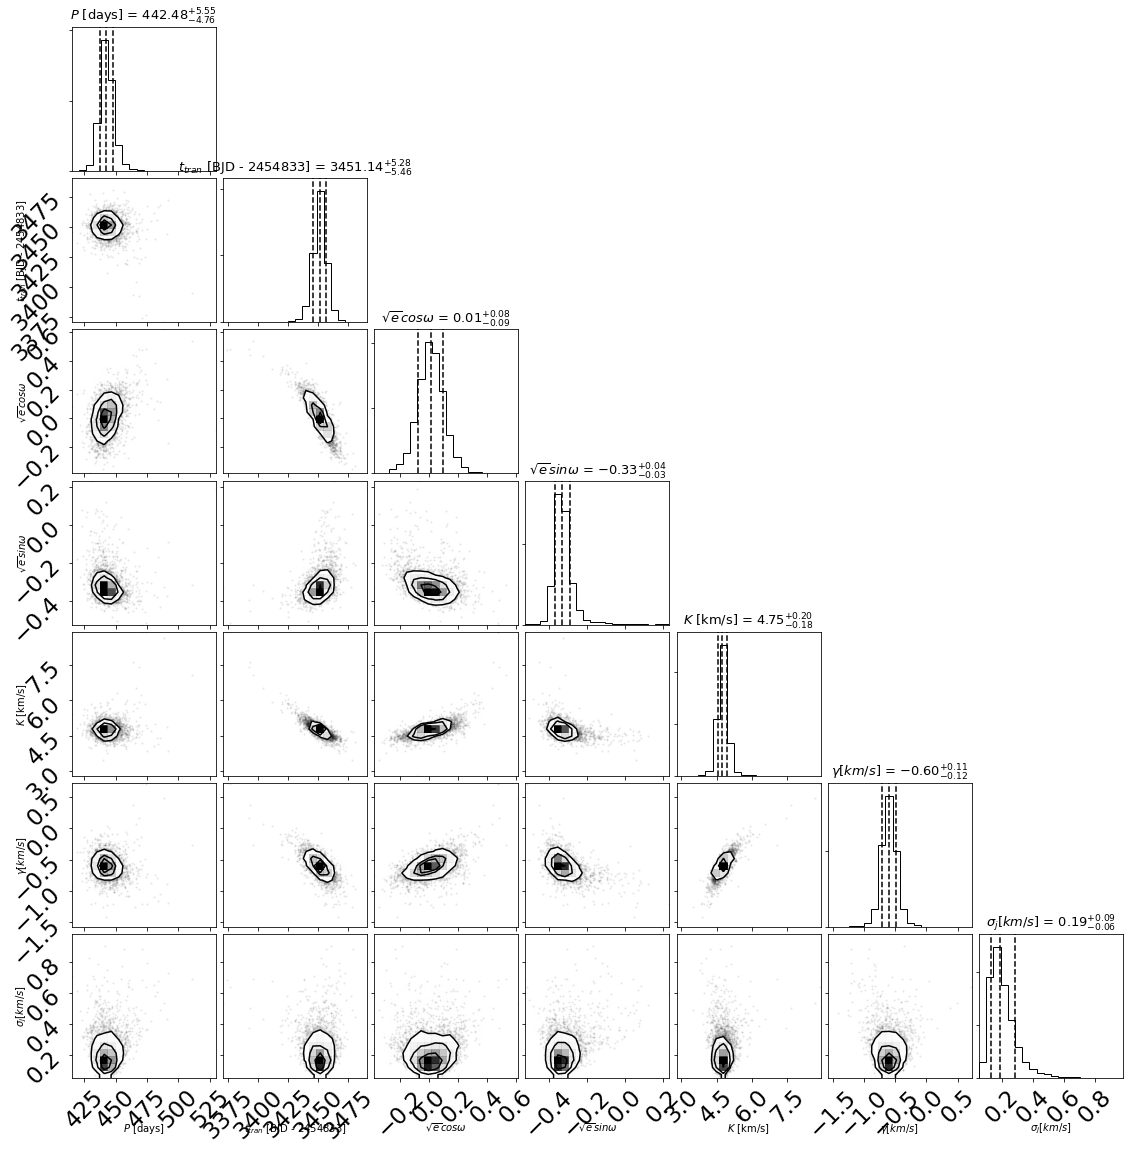

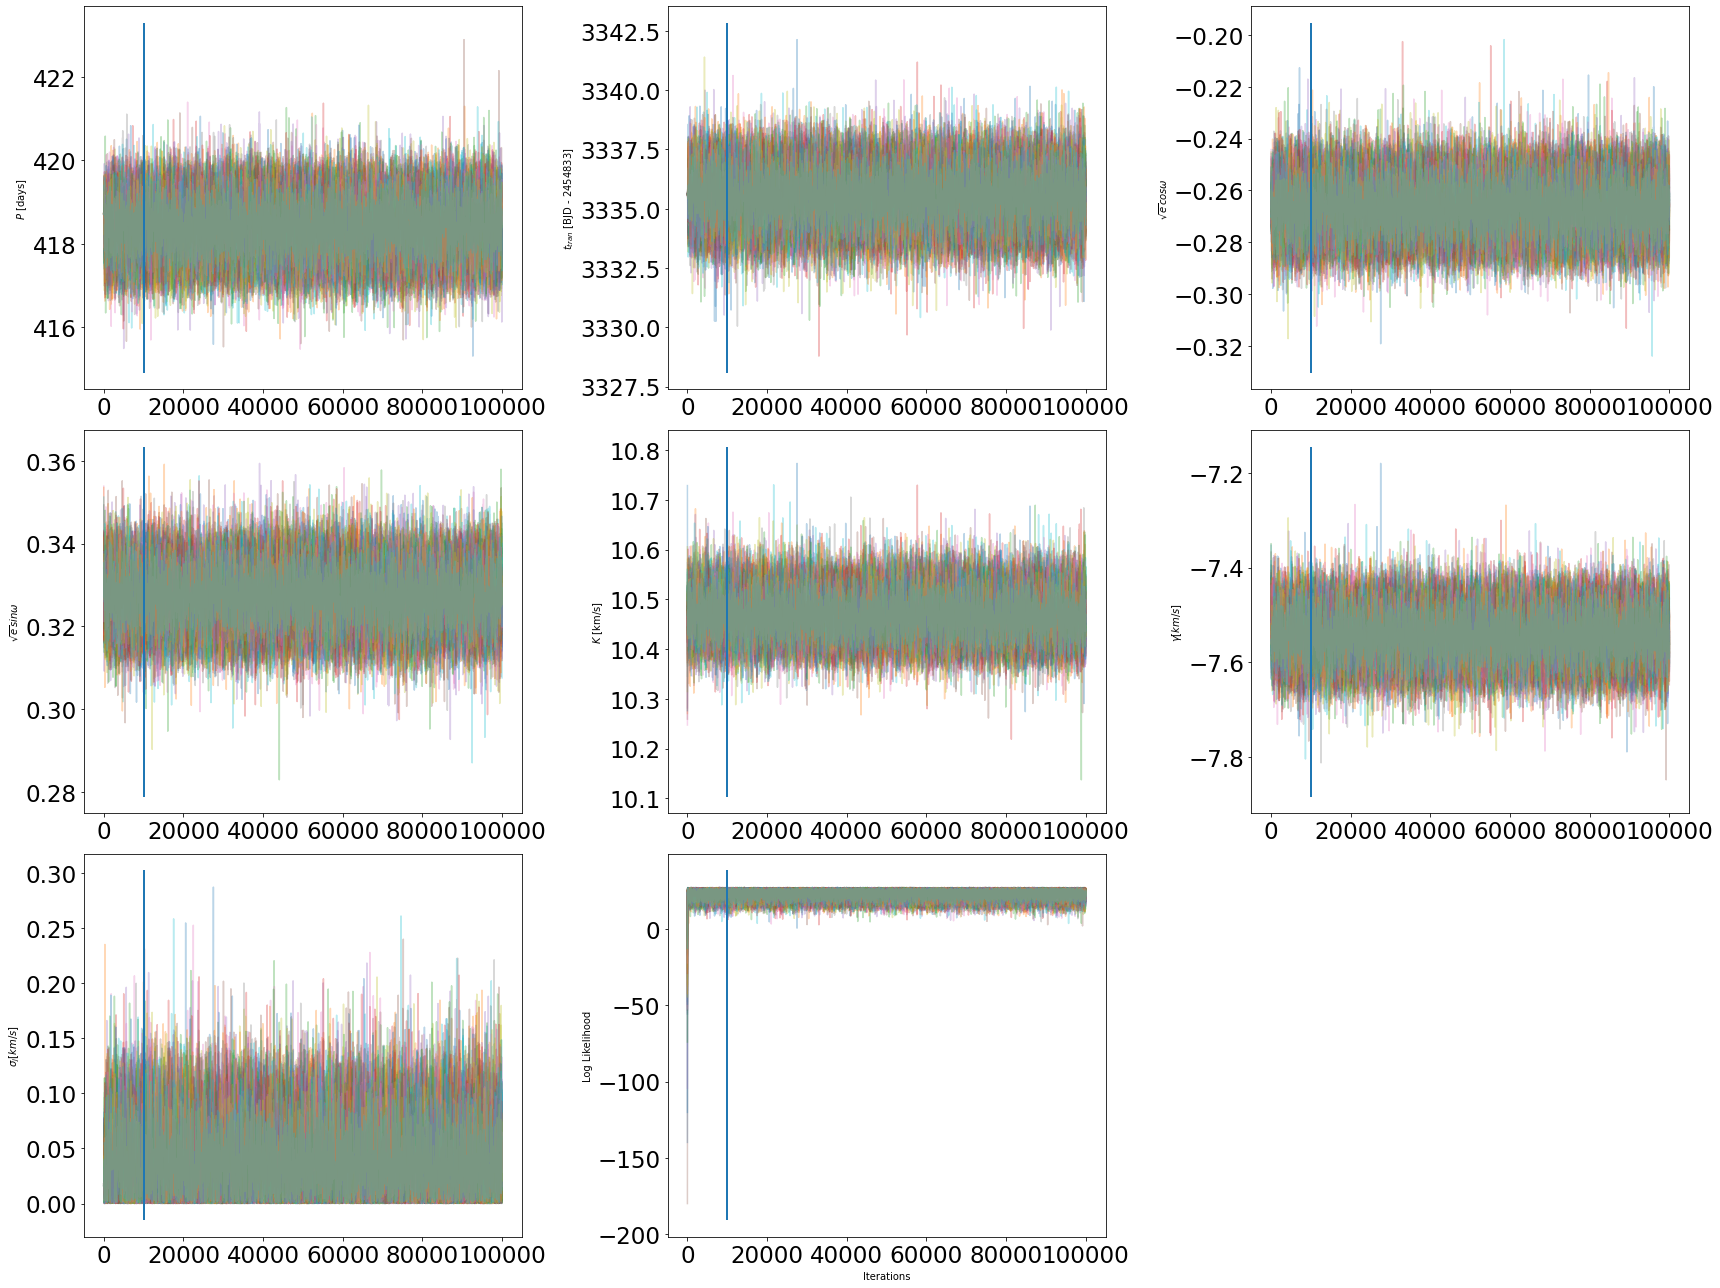

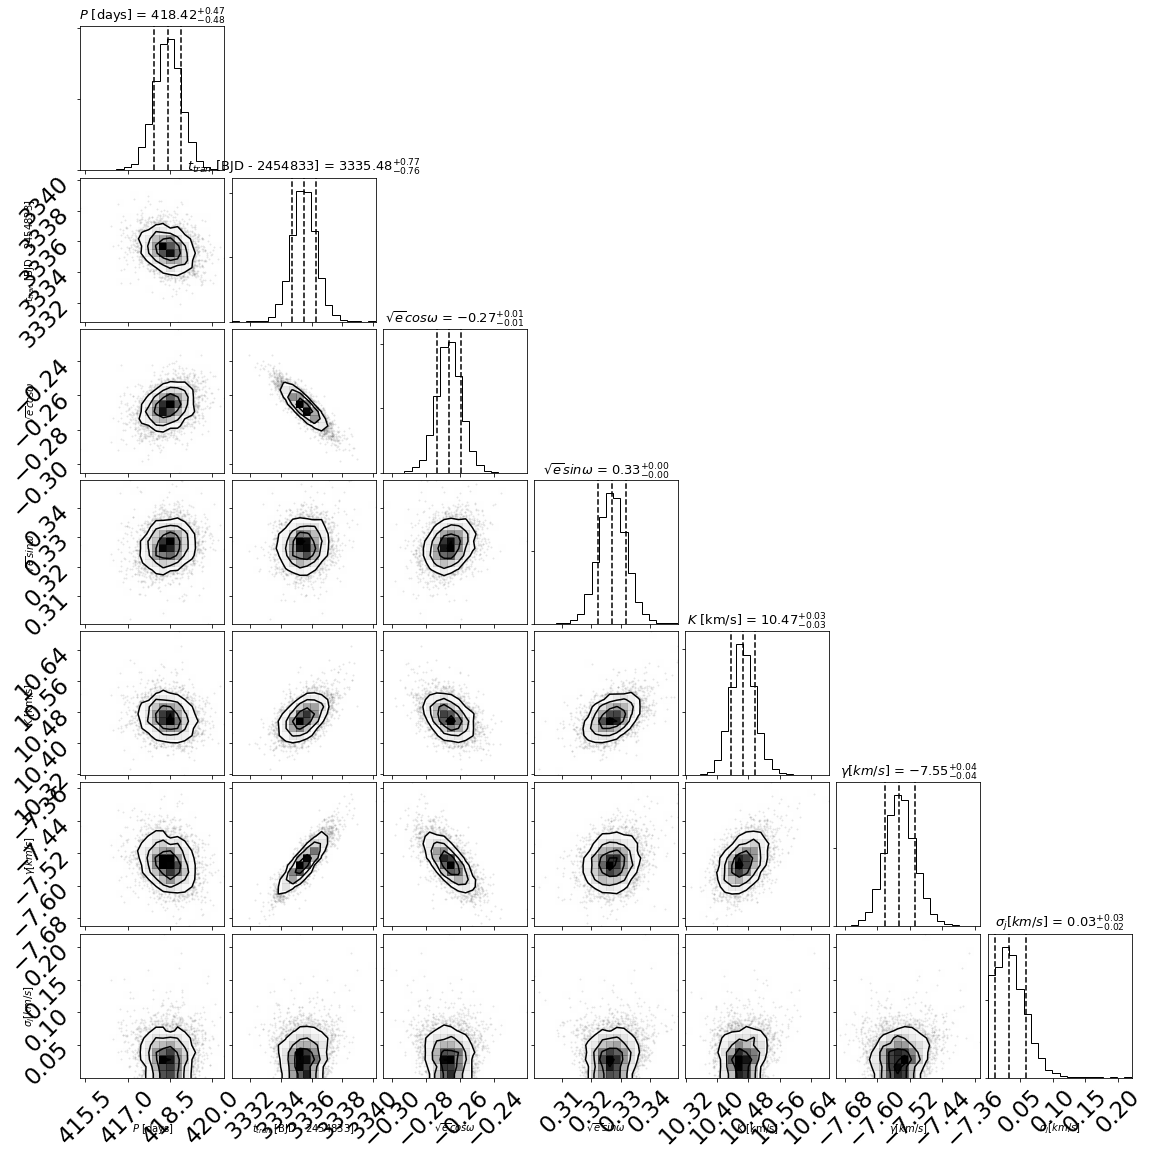

In [28]:
posteriors_all = []
med_all = []
max_all = []
minus_stdev_all = []
plus_stdev_all = []
kics = []
labels = ['$P$ [days]', '$t_{tran}$ [BJD - 2454833]', '$\sqrt{e} cos\omega$', '$\sqrt{e} sin\omega$', 
'$K$ [km/s]', '$\gamma [km/s]$', '$\sigma_{j} [km/s]$']
nparams = len(labels)
burnin = 10000


for ii in range(0, 4):
    kic = p_all[ii][0]
    kics.append(kic)
    print(kic)
    print('--------')
    
    filename = 'chain_test_' + kic + '_May7.csv'
    x = np.loadtxt(filename)
    # split the metadata from the chain results
    iteration = x[:, 0]
    walkers = x[:, 1]
    uwalkers = np.unique(walkers)
    loglike = x[:, 2]
    

    x = x[:, 3:]
    posteriors_all.append(x)
    
    # plot the value of each chain for each parameter as well as its log likelihood
    plt.figure(figsize = (24, 18))
    plt.clf()
    for ii in np.arange(nparams+1):
        # use 3 columns of plots
        ax = plt.subplot(int(np.ceil((nparams+1)/3.)), 3, ii+1)
        for jj in uwalkers:
            this = np.where(walkers == jj)[0]
            if ii < nparams:
                # if this chain is really long, cut down on plotting time by only
                # plotting every tenth element
                if len(iteration[this]) > 5000:
                    plt.plot(iteration[this][::10],
                             x[this, ii].reshape((-1,))[::10], alpha = 0.3)
                else:
                    plt.plot(iteration[this], x[this, ii].reshape((-1,)), alpha = 0.3)
            
            # plot the likelihood
            else:
                if len(iteration[this]) > 5000:
                    plt.plot(iteration[this][::10], loglike[this][::10], alpha = 0.3)
                else:
                    plt.plot(iteration[this], loglike[this], alpha = 0.3)
        # show the burnin location
        plt.plot([burnin, burnin], plt.ylim(), lw=2)
        # add the labels
        if ii < nparams:
            plt.ylabel(labels[ii])
        else:
            plt.ylabel('Log Likelihood')
            plt.xlabel('Iterations')
        ax.ticklabel_format(useOffset=False)
    
    plt.tight_layout()
    plt.show()

    # now remove the burnin phase
    pastburn = np.where(iteration > burnin)[0]
    iteration = iteration[pastburn]
    walkers = walkers[pastburn]
    loglike = loglike[pastburn]
    x = x[pastburn, :]
    
    
    
    # thin the file if we want to speed things up
    nthin = 1000
    thin = np.arange(0, iteration.max(), nthin)
    good = np.in1d(iteration, thin)
    x = x[good, :]
    iteration = iteration[good]
    walkers = walkers[good]
    loglike = loglike[good]
    
    ordered_indices = np.argsort(loglike)
    max_index = ordered_indices[-1]
    

    
    
    #plot corner plot
    # want samples in the shape of (nsamples, ndim)
    samples = x
    figure = corner.corner(samples,labels=labels,
                           quantiles=[0.16, 0.5, 0.84],
                           show_titles=True, title_kwargs={"fontsize": 13})


    maxim = x[max_index]
    max_all.append(maxim)
    
    
    med = []
    minus_stdev = []
    plus_stdev = []
    for ii in range(0,7):
        med.append(np.median(x[:, ii]))
        minus_stdev.append(np.median(np.quantile(x[:, ii], 0.16) - x[:, ii]))
        plus_stdev.append(np.median(np.quantile(x[:, ii], 0.84) - x[:, ii]))
        
        print(labels[ii])
        print('max = ' + str(maxim[ii]))
        print('median = ' + str(np.median(x[:, ii])))
        print('- sigma = ' + str(np.quantile(x[:, ii], 0.16) - np.median(x[:, ii])))
        print('+ sigma = ' + str(np.quantile(x[:, ii], 0.84) - np.median(x[:, ii])))
        print('')
        
    med_all.append(med)
    minus_stdev_all.append(minus_stdev)
    plus_stdev_all.append(plus_stdev)
    
    print('')
    print('')
    

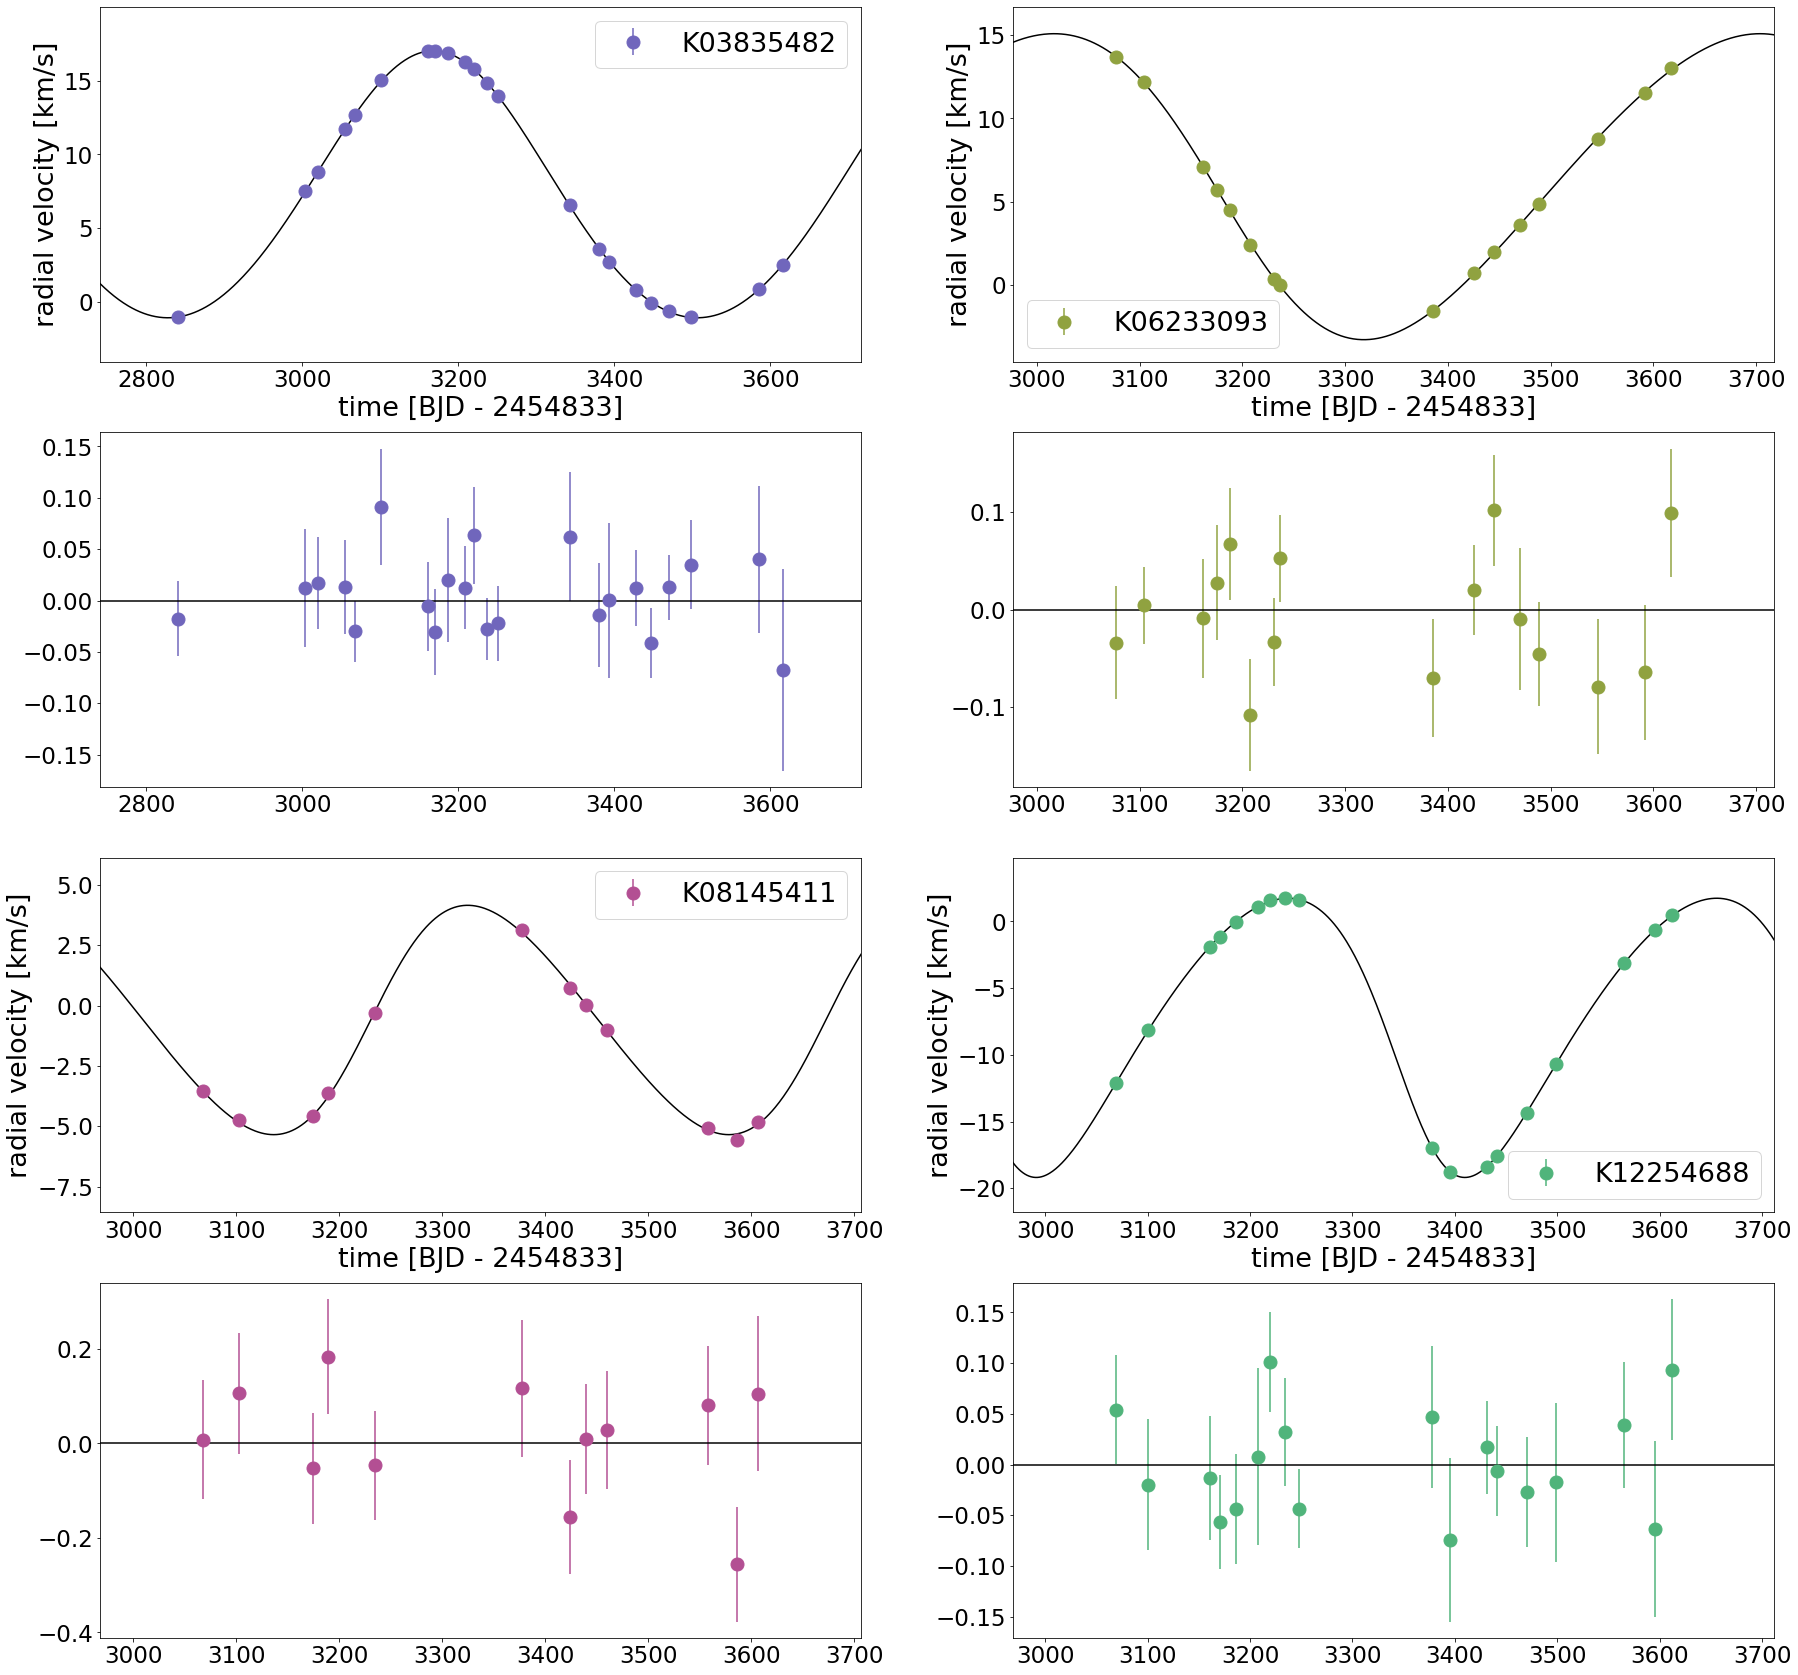

In [17]:
fig, ax = plt.subplots(4,2, figsize = [30,30])
index = 0
columns = [0,0,2,2]
resid_columns = [1,1,3,3]
rows = [0,1,0,1]
for index in range(0, len(data_all)):
    ii = columns[index]
    jj = rows[index]
    kk = resid_columns[index]
    
    params = max_all[index]
    data = data_all[index]
    
    kic = kics[index]   
    period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma, jitter = params
    
    time, rv, rv_err = data['time [BJD - 2454833]'], data['radial velocities [km/s]'], data['radial velocity errors [km/s]']
    
    time_model = np.arange(np.min(time)*0.95, np.max(time)*1.05)
    RVmodel = RV_model(time_model, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
    
    ax[ii][jj].plot(time_model, RVmodel, color = 'k')    
    
    ax[ii][jj].errorbar(time, rv, yerr = np.sqrt(rv_err**2. + jitter**2.), marker = 'o', linestyle = '', label = kic, color = colors[index], markersize = 13)
    ax[ii][jj].set_xlabel('time [BJD - 2454833]', fontsize = 27)
    ax[ii][jj].set_ylabel('radial velocity [km/s]', fontsize = 27)
    
    RVresids = RV_model(time, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
    ax[kk][jj].plot([np.min(time)*0.95, np.max(time)*1.05], [0., 0.], color = 'k')
    ax[kk][jj].errorbar(time, rv - RVresids, yerr = np.sqrt(rv_err**2. + jitter**2.), fmt = 'o', markersize = 13,  color = colors[index])
    ax[kk][jj].get_shared_x_axes().join(ax[kk][jj], ax[ii][jj])
    
    ax[ii][jj].set_xlim([np.min(time)-100, np.max(time)+100])
    ax[ii][jj].set_ylim([np.min(rv)-3, np.max(rv)+3])
    ax[ii][jj].legend(fontsize = 27)

    index += 1




K03835482
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


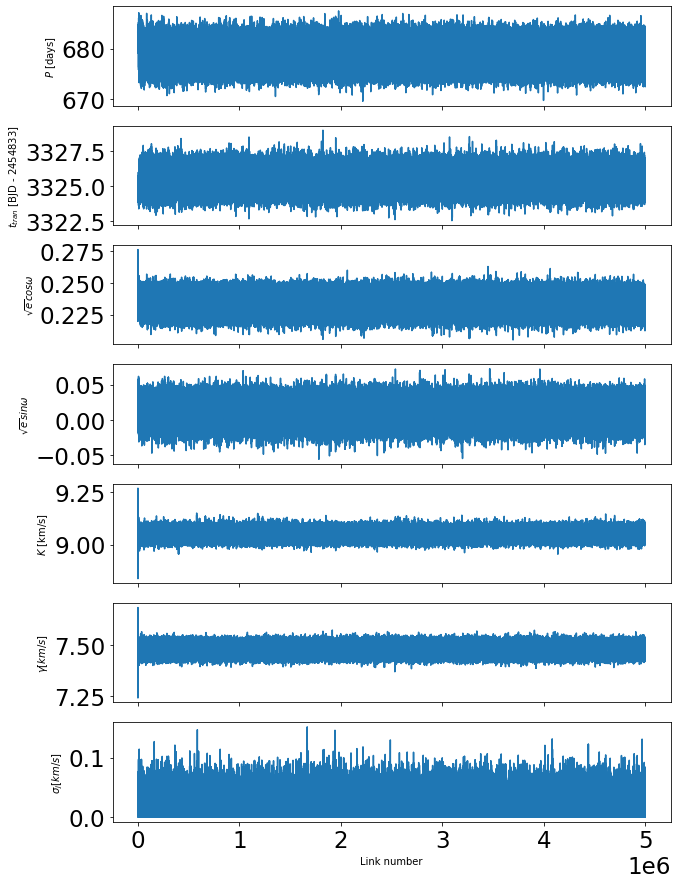

In [15]:
kic = p_all[0][0]
filename = 'chain_test_' + kic + '_May7.csv' 
print('')
print('')
print('')
print(kic)
print('--------')
x = np.loadtxt(filename)
# split the metadata from the chain results
iteration = x[:, 0]
walkers = x[:, 1]
uwalkers = np.unique(walkers)
loglike = x[:, 2]
x = x[:, 3:]
labels = ['$P$ [days]', '$t_{tran}$ [BJD - 2454833]', '$\sqrt{e} cos\omega$', '$\sqrt{e} sin\omega$', 
'$K$ [km/s]', '$\gamma [km/s]$', '$\sigma_{j} [km/s]$']


fig, ax = plt.subplots(7,1, figsize = (10,15), sharex = True)
ax[6].set_xlabel('Link number')
ax[0].set_ylabel(labels[0])
ax[1].set_ylabel(labels[1])
ax[2].set_ylabel(labels[2])
ax[3].set_ylabel(labels[3])
ax[4].set_ylabel(labels[4])
ax[5].set_ylabel(labels[5])
ax[6].set_ylabel(labels[6])
ax[0].plot(x[:, 0]);
ax[1].plot(x[:, 1]);
ax[2].plot(x[:, 2]);
ax[3].plot(x[:, 3]);
ax[4].plot(x[:, 4]);
ax[5].plot(x[:, 5]);
ax[6].plot(x[:, 6]);

#plt.savefig('chain_plots.jpg')
plt.show()





K06233093
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


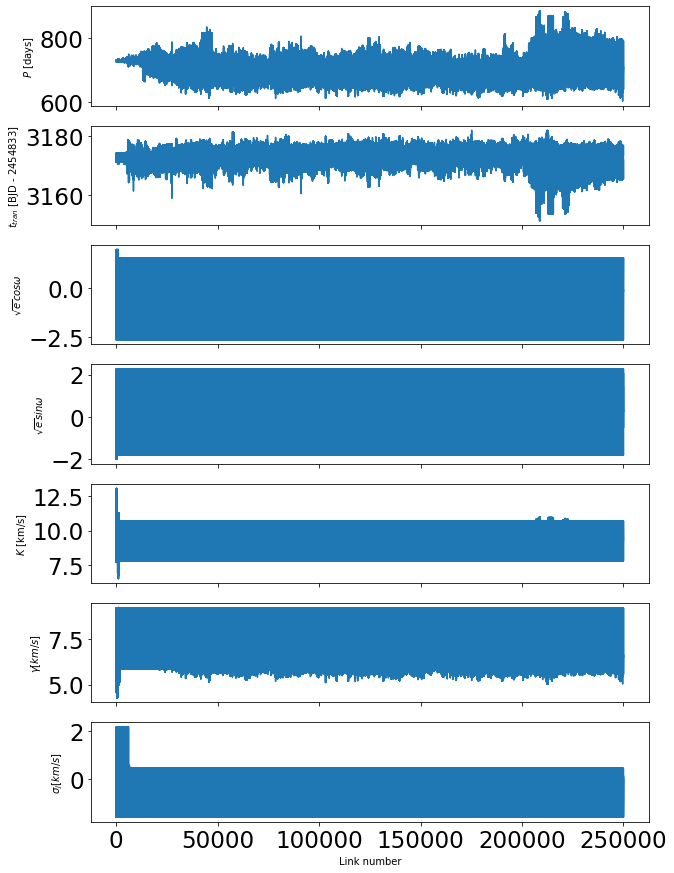

In [15]:
kic = p_all[1][0]
filename = 'chain_test_' + kic + '.csv' 
print('')
print('')
print('')
print(kic)
print('--------')
x = np.loadtxt(filename)
# split the metadata from the chain results
iteration = x[:, 0]
walkers = x[:, 1]
uwalkers = np.unique(walkers)
loglike = x[:, 2]
x = x[:, 3:]
labels = ['$P$ [days]', '$t_{tran}$ [BJD - 2454833]', '$\sqrt{e} cos\omega$', '$\sqrt{e} sin\omega$', 
'$K$ [km/s]', '$\gamma [km/s]$', '$\sigma_{j} [km/s]$']


fig, ax = plt.subplots(7,1, figsize = (10,15), sharex = True)
ax[6].set_xlabel('Link number')
ax[0].set_ylabel(labels[0])
ax[1].set_ylabel(labels[1])
ax[2].set_ylabel(labels[2])
ax[3].set_ylabel(labels[3])
ax[4].set_ylabel(labels[4])
ax[5].set_ylabel(labels[5])
ax[6].set_ylabel(labels[6])
ax[0].plot(x[:, 0]);
ax[1].plot(x[:, 1]);
ax[2].plot(x[:, 2]);
ax[3].plot(x[:, 3]);
ax[4].plot(x[:, 4]);
ax[5].plot(x[:, 5]);
ax[6].plot(x[:, 6]);
plt.show()




K08145411
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


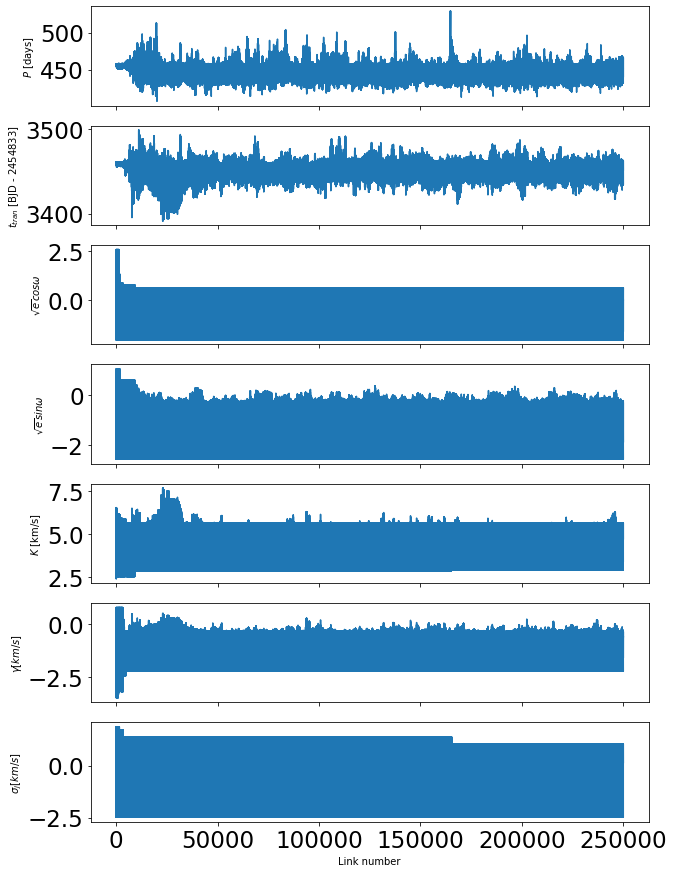

In [16]:
kic = p_all[2][0]
filename = 'chain_test_' + kic + '.csv' 
print('')
print('')
print('')
print(kic)
print('--------')
x = np.loadtxt(filename)
# split the metadata from the chain results
iteration = x[:, 0]
walkers = x[:, 1]
uwalkers = np.unique(walkers)
loglike = x[:, 2]
x = x[:, 3:]
labels = ['$P$ [days]', '$t_{tran}$ [BJD - 2454833]', '$\sqrt{e} cos\omega$', '$\sqrt{e} sin\omega$', 
'$K$ [km/s]', '$\gamma [km/s]$', '$\sigma_{j} [km/s]$']


fig, ax = plt.subplots(7,1, figsize = (10,15), sharex = True)
ax[6].set_xlabel('Link number')
ax[0].set_ylabel(labels[0])
ax[1].set_ylabel(labels[1])
ax[2].set_ylabel(labels[2])
ax[3].set_ylabel(labels[3])
ax[4].set_ylabel(labels[4])
ax[5].set_ylabel(labels[5])
ax[6].set_ylabel(labels[6])
ax[0].plot(x[:, 0]);
ax[1].plot(x[:, 1]);
ax[2].plot(x[:, 2]);
ax[3].plot(x[:, 3]);
ax[4].plot(x[:, 4]);
ax[5].plot(x[:, 5]);
ax[6].plot(x[:, 6]);
plt.show()




K12254688
--------


/Users/Danielyahalomi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


median($P$ [days]) = 418.5316703111277
median($t_{tran}$ [BJD - 2454833]) = 3335.5017059363618
median($\sqrt{e} cos\omega$) = -0.2673300338247814
median($\sqrt{e} sin\omega$) = 0.32816388058187346
median($K$ [km/s]) = 10.46773358250875
median($\gamma [km/s]$) = -7.5362191263834415
median($\sigma_{j} [km/s]$) = 0.021661611937837593


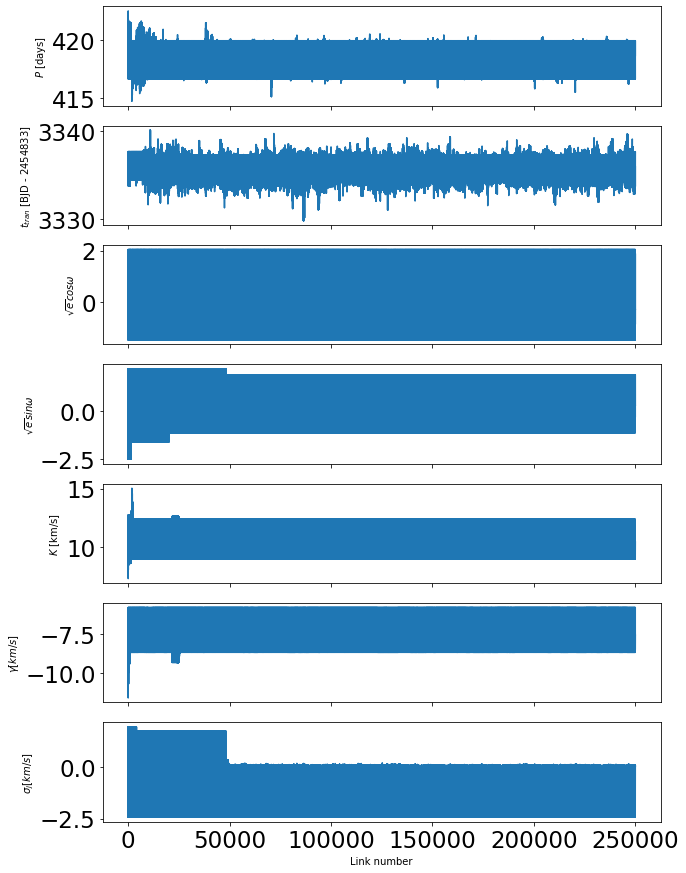

In [18]:
kic = p_all[3][0]
filename = 'chain_test_' + kic + '.csv' 
print('')
print('')
print('')
print(kic)
print('--------')
x = np.loadtxt(filename)
# split the metadata from the chain results
iteration = x[:, 0]
walkers = x[:, 1]
uwalkers = np.unique(walkers)
loglike = x[:, 2]
x = x[:, 3:]
labels = ['$P$ [days]', '$t_{tran}$ [BJD - 2454833]', '$\sqrt{e} cos\omega$', '$\sqrt{e} sin\omega$', 
'$K$ [km/s]', '$\gamma [km/s]$', '$\sigma_{j} [km/s]$']


fig, ax = plt.subplots(7,1, figsize = (10,15), sharex = True)
ax[6].set_xlabel('Link number')
ax[0].set_ylabel(labels[0])
ax[1].set_ylabel(labels[1])
ax[2].set_ylabel(labels[2])
ax[3].set_ylabel(labels[3])
ax[4].set_ylabel(labels[4])
ax[5].set_ylabel(labels[5])
ax[6].set_ylabel(labels[6])
ax[0].plot(x[:, 0]);
ax[1].plot(x[:, 1]);
ax[2].plot(x[:, 2]);
ax[3].plot(x[:, 3]);
ax[4].plot(x[:, 4]);
ax[5].plot(x[:, 5]);
ax[6].plot(x[:, 6]);
plt.show()

#RV params = period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma, jitter
params = []
for ii in range(0,7):
    print('median('+labels[ii]+') = ' + str(np.median(x[:, ii])))
    params.append(np.median(x[:, ii]))
    
    
posterior_all.append(params)

In [ ]:
fig, ax = plt.subplots(4,2, figsize = [30,30])
index = 0
columns = [0,0,2,2]
resid_columns = [1,1,3,3]
rows = [0,1,0,1]
for index in range(0, len(data_all)):
    ii = columns[index]
    jj = rows[index]
    kk = resid_columns[index]
    
    params = p_all[index]
    data = data_all[index]
    
    kic = params[0]    
    period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma = params[1:-1]
    jitter = params[-1]
    
    time, rv, rv_err = data['time [BJD - 2454833]'], data['radial velocities [km/s]'], data['radial velocity errors [km/s]']
    
    time_model = np.arange(np.min(time)*0.95, np.max(time)*1.05)
    RVmodel = RV_model(time_model, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
    
    ax[ii][jj].plot(time_model, RVmodel, color = 'k')    
    
    ax[ii][jj].errorbar(time, rv, yerr = np.sqrt(rv_err**2. + jitter**2.), marker = 'o', linestyle = '', label = kic, color = colors[index], markersize = 13)
    ax[ii][jj].set_xlabel('time [BJD - 2454833]', fontsize = 27)
    ax[ii][jj].set_ylabel('radial velocity [km/s]', fontsize = 27)
    
    RVresids = RV_model(time, period, ttran, sqrte_cosomega, sqrte_sinomega, K, gamma)
    ax[kk][jj].plot([np.min(time)*0.95, np.max(time)*1.05], [0., 0.], color = 'k')
    ax[kk][jj].errorbar(time, rv - RVresids, yerr = np.sqrt(rv_err**2. + jitter**2.), fmt = 'o', markersize = 13,  color = colors[index])
    ax[kk][jj].get_shared_x_axes().join(ax[kk][jj], ax[ii][jj])
    
    ax[ii][jj].set_xlim([np.min(time)-100, np.max(time)+100])
    ax[ii][jj].set_ylim([np.min(rv)-3, np.max(rv)+3])
    ax[ii][jj].legend(fontsize = 27)

    index += 1